## 🧠 Summary

This notebook applies a Variational Autoencoder (VAE) to session-wise resting-state functional connectivity (FC) patterns to explore how TMS modulates brain-wide activity.

- FC patterns are derived using the AAL atlas (116 ROIs; some with NaN values), resulting in symmetric FC matrices per session.
- Data includes 48 subjects, each with 7 sessions by default (5 sessions are missing overall).
- A fully connected VAE with ReLU activation is implemented to learn latent representations from flattened FC matrices.
- This version is called **_raw**, as another **_weighted (subject × condition balanced)** setup is included for comparison.

---

## 🔍 Main findings so far

- The VAE successfully captures **subject-specific FC profiles** in the latent embedding space.
- To evaluate TMS effects, I computed the **Euclidean distance** between the mean embedding of each sham/real session and the subject’s null session mean, then compared sham vs. real. 
- A promising trend emerged: **distance from real TMS to null was greater** than distance from sham to null.
- Attempted to split TMS effects by **stimulation location (aOFC vs. pOFC)**, but did not find clear differential patterns.
- Attempted to use downstream classifier (RF) to classify the latent representations but found nothing.


In [3]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# fix the random seeds for Python, NumPy, and PyTorch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
sub_cond_path = '/Users/liuq13/NODEAP_scripts/data_input/SubConds.xlsx'
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [8]:
# Load and preprocess
# load aal FC matrix
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, base_nifti_folder, mat_filename='conn_matrix.mat')
X_tensor = preprocess_for_torch(all_corr_data)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # each batch has 32 samples

[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_44/S1D1/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix.mat
Columns with NaN: 229 / 6670
Tensor shape after preprocessing: torch.Size([331, 6441])


In [9]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
NUM_EPOCH = 1000
LR = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=device, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/1000: 100%|█████████████████████████████| 11/11 [00:00<00:00, 65.95it/s]


Epoch 1, Loss: 6796.3783, Recon: 6795.2702, KL: 1.1081

===== Epoch 2 =====


Epoch 2/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 104.93it/s]


Epoch 2, Loss: 6616.2947, Recon: 6612.4700, KL: 3.8248

===== Epoch 3 =====


Epoch 3/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 103.94it/s]


Epoch 3, Loss: 6509.2939, Recon: 6502.9934, KL: 6.3004

===== Epoch 4 =====


Epoch 4/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 108.73it/s]


Epoch 4, Loss: 6393.1363, Recon: 6383.1156, KL: 10.0207

===== Epoch 5 =====


Epoch 5/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 107.79it/s]


Epoch 5, Loss: 6172.4882, Recon: 6156.3669, KL: 16.1213

===== Epoch 6 =====


Epoch 6/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 120.99it/s]


Epoch 6, Loss: 5903.8747, Recon: 5882.4783, KL: 21.3963

===== Epoch 7 =====


Epoch 7/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 128.56it/s]


Epoch 7, Loss: 5654.3532, Recon: 5628.1453, KL: 26.2078

===== Epoch 8 =====


Epoch 8/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 111.01it/s]


Epoch 8, Loss: 5421.8315, Recon: 5391.2779, KL: 30.5537

===== Epoch 9 =====


Epoch 9/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 113.43it/s]


Epoch 9, Loss: 5223.1772, Recon: 5188.9971, KL: 34.1800

===== Epoch 10 =====


Epoch 10/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.09it/s]


Epoch 10, Loss: 5061.7787, Recon: 5025.0128, KL: 36.7659

===== Epoch 11 =====


Epoch 11/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 68.28it/s]


Epoch 11, Loss: 4933.2695, Recon: 4894.0332, KL: 39.2364

===== Epoch 12 =====


Epoch 12/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 137.26it/s]


Epoch 12, Loss: 4814.2955, Recon: 4773.1476, KL: 41.1478

===== Epoch 13 =====


Epoch 13/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 142.13it/s]


Epoch 13, Loss: 4711.1669, Recon: 4667.9642, KL: 43.2027

===== Epoch 14 =====


Epoch 14/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 137.25it/s]


Epoch 14, Loss: 4629.9288, Recon: 4584.4913, KL: 45.4375

===== Epoch 15 =====


Epoch 15/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.71it/s]


Epoch 15, Loss: 4551.3252, Recon: 4504.6241, KL: 46.7012

===== Epoch 16 =====


Epoch 16/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 135.21it/s]


Epoch 16, Loss: 4484.3018, Recon: 4435.4633, KL: 48.8385

===== Epoch 17 =====


Epoch 17/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 142.50it/s]


Epoch 17, Loss: 4417.0973, Recon: 4366.8242, KL: 50.2731

===== Epoch 18 =====


Epoch 18/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.81it/s]


Epoch 18, Loss: 4349.1707, Recon: 4297.0342, KL: 52.1365

===== Epoch 19 =====


Epoch 19/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 145.92it/s]


Epoch 19, Loss: 4292.6184, Recon: 4239.1302, KL: 53.4882

===== Epoch 20 =====


Epoch 20/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.38it/s]


Epoch 20, Loss: 4235.4890, Recon: 4178.9962, KL: 56.4929

===== Epoch 21 =====


Epoch 21/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.79it/s]


Epoch 21, Loss: 4177.7081, Recon: 4120.9600, KL: 56.7481

===== Epoch 22 =====


Epoch 22/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.13it/s]


Epoch 22, Loss: 4127.1051, Recon: 4067.2256, KL: 59.8796

===== Epoch 23 =====


Epoch 23/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.49it/s]


Epoch 23, Loss: 4075.7354, Recon: 4015.0034, KL: 60.7320

===== Epoch 24 =====


Epoch 24/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.53it/s]


Epoch 24, Loss: 4031.8601, Recon: 3968.3055, KL: 63.5545

===== Epoch 25 =====


Epoch 25/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.61it/s]


Epoch 25, Loss: 3983.8908, Recon: 3919.3164, KL: 64.5745

===== Epoch 26 =====


Epoch 26/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 128.09it/s]


Epoch 26, Loss: 3934.3880, Recon: 3866.9647, KL: 67.4233

===== Epoch 27 =====


Epoch 27/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.18it/s]


Epoch 27, Loss: 3893.0811, Recon: 3824.5794, KL: 68.5017

===== Epoch 28 =====


Epoch 28/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.12it/s]


Epoch 28, Loss: 3850.9157, Recon: 3780.3459, KL: 70.5698

===== Epoch 29 =====


Epoch 29/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.35it/s]


Epoch 29, Loss: 3808.3078, Recon: 3736.1078, KL: 72.2000

===== Epoch 30 =====


Epoch 30/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 159.94it/s]


Epoch 30, Loss: 3768.9907, Recon: 3695.1104, KL: 73.8803

===== Epoch 31 =====


Epoch 31/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.17it/s]


Epoch 31, Loss: 3731.5464, Recon: 3656.3345, KL: 75.2120

===== Epoch 32 =====


Epoch 32/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.00it/s]


Epoch 32, Loss: 3694.2134, Recon: 3616.5503, KL: 77.6631

===== Epoch 33 =====


Epoch 33/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 161.78it/s]


Epoch 33, Loss: 3662.3920, Recon: 3583.7092, KL: 78.6828

===== Epoch 34 =====


Epoch 34/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 160.08it/s]


Epoch 34, Loss: 3627.9371, Recon: 3547.3657, KL: 80.5715

===== Epoch 35 =====


Epoch 35/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 136.41it/s]


Epoch 35, Loss: 3596.9651, Recon: 3515.0873, KL: 81.8778

===== Epoch 36 =====


Epoch 36/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 125.96it/s]


Epoch 36, Loss: 3561.4435, Recon: 3478.0423, KL: 83.4012

===== Epoch 37 =====


Epoch 37/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.61it/s]


Epoch 37, Loss: 3532.8593, Recon: 3447.9634, KL: 84.8960

===== Epoch 38 =====


Epoch 38/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 86.43it/s]


Epoch 38, Loss: 3504.0964, Recon: 3417.8346, KL: 86.2617

===== Epoch 39 =====


Epoch 39/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.72it/s]


Epoch 39, Loss: 3475.3557, Recon: 3387.8946, KL: 87.4610

===== Epoch 40 =====


Epoch 40/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 99.98it/s]


Epoch 40, Loss: 3451.1647, Recon: 3362.1607, KL: 89.0040

===== Epoch 41 =====


Epoch 41/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 93.17it/s]


Epoch 41, Loss: 3428.9151, Recon: 3338.5785, KL: 90.3366

===== Epoch 42 =====


Epoch 42/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 100.10it/s]


Epoch 42, Loss: 3407.6749, Recon: 3315.8001, KL: 91.8748

===== Epoch 43 =====


Epoch 43/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.90it/s]


Epoch 43, Loss: 3382.2567, Recon: 3289.5690, KL: 92.6877

===== Epoch 44 =====


Epoch 44/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.94it/s]


Epoch 44, Loss: 3360.1710, Recon: 3265.9320, KL: 94.2390

===== Epoch 45 =====


Epoch 45/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.86it/s]


Epoch 45, Loss: 3336.1823, Recon: 3241.1049, KL: 95.0774

===== Epoch 46 =====


Epoch 46/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.73it/s]


Epoch 46, Loss: 3314.7737, Recon: 3218.7114, KL: 96.0622

===== Epoch 47 =====


Epoch 47/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 101.28it/s]


Epoch 47, Loss: 3295.9358, Recon: 3199.2745, KL: 96.6614

===== Epoch 48 =====


Epoch 48/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 100.74it/s]


Epoch 48, Loss: 3279.3381, Recon: 3181.2764, KL: 98.0617

===== Epoch 49 =====


Epoch 49/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.33it/s]


Epoch 49, Loss: 3260.3191, Recon: 3162.2838, KL: 98.0353

===== Epoch 50 =====


Epoch 50/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.79it/s]


Epoch 50, Loss: 3240.9400, Recon: 3141.3282, KL: 99.6118

===== Epoch 51 =====


Epoch 51/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.22it/s]


Epoch 51, Loss: 3221.5386, Recon: 3121.8863, KL: 99.6523

===== Epoch 52 =====


Epoch 52/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.23it/s]


Epoch 52, Loss: 3200.9373, Recon: 3099.2606, KL: 101.6767

===== Epoch 53 =====


Epoch 53/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.82it/s]


Epoch 53, Loss: 3186.0424, Recon: 3084.8365, KL: 101.2059

===== Epoch 54 =====


Epoch 54/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.49it/s]


Epoch 54, Loss: 3170.0133, Recon: 3067.3206, KL: 102.6927

===== Epoch 55 =====


Epoch 55/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.70it/s]


Epoch 55, Loss: 3153.5369, Recon: 3051.1366, KL: 102.4003

===== Epoch 56 =====


Epoch 56/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.13it/s]


Epoch 56, Loss: 3140.5221, Recon: 3037.4944, KL: 103.0278

===== Epoch 57 =====


Epoch 57/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.74it/s]


Epoch 57, Loss: 3127.7262, Recon: 3024.0411, KL: 103.6851

===== Epoch 58 =====


Epoch 58/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.44it/s]


Epoch 58, Loss: 3115.4345, Recon: 3010.7439, KL: 104.6906

===== Epoch 59 =====


Epoch 59/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 95.28it/s]


Epoch 59, Loss: 3101.4498, Recon: 2996.2624, KL: 105.1874

===== Epoch 60 =====


Epoch 60/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 92.14it/s]


Epoch 60, Loss: 3086.6430, Recon: 2981.2097, KL: 105.4333

===== Epoch 61 =====


Epoch 61/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 93.73it/s]


Epoch 61, Loss: 3075.4339, Recon: 2969.6764, KL: 105.7575

===== Epoch 62 =====


Epoch 62/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 94.55it/s]


Epoch 62, Loss: 3066.5074, Recon: 2959.8909, KL: 106.6165

===== Epoch 63 =====


Epoch 63/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 94.79it/s]


Epoch 63, Loss: 3067.9846, Recon: 2961.1831, KL: 106.8015

===== Epoch 64 =====


Epoch 64/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.19it/s]


Epoch 64, Loss: 3054.4506, Recon: 2947.6233, KL: 106.8273

===== Epoch 65 =====


Epoch 65/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 94.88it/s]


Epoch 65, Loss: 3032.8447, Recon: 2925.6548, KL: 107.1899

===== Epoch 66 =====


Epoch 66/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 98.18it/s]


Epoch 66, Loss: 3013.8739, Recon: 2905.9562, KL: 107.9177

===== Epoch 67 =====


Epoch 67/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.16it/s]


Epoch 67, Loss: 3006.8601, Recon: 2899.3034, KL: 107.5568

===== Epoch 68 =====


Epoch 68/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.75it/s]


Epoch 68, Loss: 2995.5018, Recon: 2887.2798, KL: 108.2220

===== Epoch 69 =====


Epoch 69/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.16it/s]


Epoch 69, Loss: 2986.7509, Recon: 2878.0836, KL: 108.6672

===== Epoch 70 =====


Epoch 70/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.39it/s]


Epoch 70, Loss: 2974.0259, Recon: 2865.4265, KL: 108.5994

===== Epoch 71 =====


Epoch 71/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.04it/s]


Epoch 71, Loss: 2962.8167, Recon: 2853.2177, KL: 109.5990

===== Epoch 72 =====


Epoch 72/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.12it/s]


Epoch 72, Loss: 2948.0445, Recon: 2839.5311, KL: 108.5133

===== Epoch 73 =====


Epoch 73/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.25it/s]


Epoch 73, Loss: 2940.9996, Recon: 2830.8731, KL: 110.1266

===== Epoch 74 =====


Epoch 74/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.87it/s]


Epoch 74, Loss: 2935.1518, Recon: 2826.1647, KL: 108.9870

===== Epoch 75 =====


Epoch 75/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.23it/s]


Epoch 75, Loss: 2925.3075, Recon: 2815.8660, KL: 109.4415

===== Epoch 76 =====


Epoch 76/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.95it/s]


Epoch 76, Loss: 2918.5700, Recon: 2808.6286, KL: 109.9414

===== Epoch 77 =====


Epoch 77/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.98it/s]


Epoch 77, Loss: 2910.4773, Recon: 2800.2640, KL: 110.2132

===== Epoch 78 =====


Epoch 78/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.45it/s]


Epoch 78, Loss: 2903.1287, Recon: 2793.3049, KL: 109.8238

===== Epoch 79 =====


Epoch 79/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.22it/s]


Epoch 79, Loss: 2899.5469, Recon: 2788.6183, KL: 110.9286

===== Epoch 80 =====


Epoch 80/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.67it/s]


Epoch 80, Loss: 2886.1180, Recon: 2776.3998, KL: 109.7182

===== Epoch 81 =====


Epoch 81/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.78it/s]


Epoch 81, Loss: 2878.7458, Recon: 2767.5309, KL: 111.2149

===== Epoch 82 =====


Epoch 82/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.62it/s]


Epoch 82, Loss: 2870.8125, Recon: 2760.6683, KL: 110.1441

===== Epoch 83 =====


Epoch 83/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.67it/s]


Epoch 83, Loss: 2866.3173, Recon: 2755.5108, KL: 110.8066

===== Epoch 84 =====


Epoch 84/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.65it/s]


Epoch 84, Loss: 2857.9880, Recon: 2747.0062, KL: 110.9819

===== Epoch 85 =====


Epoch 85/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.71it/s]


Epoch 85, Loss: 2853.4721, Recon: 2742.4791, KL: 110.9931

===== Epoch 86 =====


Epoch 86/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.82it/s]


Epoch 86, Loss: 2847.2160, Recon: 2736.4560, KL: 110.7600

===== Epoch 87 =====


Epoch 87/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.00it/s]


Epoch 87, Loss: 2837.0409, Recon: 2724.9452, KL: 112.0957

===== Epoch 88 =====


Epoch 88/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.18it/s]


Epoch 88, Loss: 2830.9655, Recon: 2719.9776, KL: 110.9879

===== Epoch 89 =====


Epoch 89/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.84it/s]


Epoch 89, Loss: 2822.9610, Recon: 2711.5988, KL: 111.3621

===== Epoch 90 =====


Epoch 90/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.98it/s]


Epoch 90, Loss: 2817.2335, Recon: 2706.6303, KL: 110.6033

===== Epoch 91 =====


Epoch 91/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.09it/s]


Epoch 91, Loss: 2810.7655, Recon: 2699.5832, KL: 111.1823

===== Epoch 92 =====


Epoch 92/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.95it/s]


Epoch 92, Loss: 2809.0691, Recon: 2698.0159, KL: 111.0532

===== Epoch 93 =====


Epoch 93/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.13it/s]


Epoch 93, Loss: 2802.2217, Recon: 2690.3878, KL: 111.8339

===== Epoch 94 =====


Epoch 94/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.98it/s]


Epoch 94, Loss: 2797.9761, Recon: 2686.4977, KL: 111.4783

===== Epoch 95 =====


Epoch 95/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.86it/s]


Epoch 95, Loss: 2793.9970, Recon: 2682.1114, KL: 111.8857

===== Epoch 96 =====


Epoch 96/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.94it/s]


Epoch 96, Loss: 2786.7498, Recon: 2674.9847, KL: 111.7651

===== Epoch 97 =====


Epoch 97/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.56it/s]


Epoch 97, Loss: 2784.1232, Recon: 2672.2277, KL: 111.8955

===== Epoch 98 =====


Epoch 98/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.04it/s]


Epoch 98, Loss: 2775.1420, Recon: 2663.4967, KL: 111.6453

===== Epoch 99 =====


Epoch 99/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.62it/s]


Epoch 99, Loss: 2770.9806, Recon: 2659.1946, KL: 111.7860

===== Epoch 100 =====


Epoch 100/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.36it/s]


Epoch 100, Loss: 2763.5266, Recon: 2651.7039, KL: 111.8226

===== Epoch 101 =====


Epoch 101/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.50it/s]


Epoch 101, Loss: 2759.8049, Recon: 2648.1616, KL: 111.6434

===== Epoch 102 =====


Epoch 102/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.02it/s]


Epoch 102, Loss: 2756.8082, Recon: 2645.7737, KL: 111.0345

===== Epoch 103 =====


Epoch 103/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.39it/s]


Epoch 103, Loss: 2749.5975, Recon: 2637.3889, KL: 112.2086

===== Epoch 104 =====


Epoch 104/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.25it/s]


Epoch 104, Loss: 2744.0843, Recon: 2632.7186, KL: 111.3657

===== Epoch 105 =====


Epoch 105/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.91it/s]


Epoch 105, Loss: 2738.8975, Recon: 2626.7370, KL: 112.1605

===== Epoch 106 =====


Epoch 106/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.76it/s]


Epoch 106, Loss: 2732.7076, Recon: 2621.1188, KL: 111.5889

===== Epoch 107 =====


Epoch 107/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.83it/s]


Epoch 107, Loss: 2728.8013, Recon: 2617.5895, KL: 111.2119

===== Epoch 108 =====


Epoch 108/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.37it/s]


Epoch 108, Loss: 2725.7209, Recon: 2613.1691, KL: 112.5518

===== Epoch 109 =====


Epoch 109/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.21it/s]


Epoch 109, Loss: 2720.4093, Recon: 2609.2501, KL: 111.1592

===== Epoch 110 =====


Epoch 110/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.08it/s]


Epoch 110, Loss: 2719.2988, Recon: 2607.5393, KL: 111.7596

===== Epoch 111 =====


Epoch 111/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.98it/s]


Epoch 111, Loss: 2715.4567, Recon: 2603.3278, KL: 112.1289

===== Epoch 112 =====


Epoch 112/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.31it/s]


Epoch 112, Loss: 2708.1397, Recon: 2596.3140, KL: 111.8258

===== Epoch 113 =====


Epoch 113/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.24it/s]


Epoch 113, Loss: 2703.1686, Recon: 2591.8435, KL: 111.3251

===== Epoch 114 =====


Epoch 114/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.58it/s]


Epoch 114, Loss: 2701.6663, Recon: 2589.8305, KL: 111.8358

===== Epoch 115 =====


Epoch 115/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.77it/s]


Epoch 115, Loss: 2697.5133, Recon: 2585.7476, KL: 111.7657

===== Epoch 116 =====


Epoch 116/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.45it/s]


Epoch 116, Loss: 2693.9932, Recon: 2582.3444, KL: 111.6488

===== Epoch 117 =====


Epoch 117/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.88it/s]


Epoch 117, Loss: 2692.8841, Recon: 2580.4945, KL: 112.3896

===== Epoch 118 =====


Epoch 118/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.73it/s]


Epoch 118, Loss: 2686.9462, Recon: 2575.3507, KL: 111.5955

===== Epoch 119 =====


Epoch 119/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.32it/s]


Epoch 119, Loss: 2684.4224, Recon: 2571.8886, KL: 112.5338

===== Epoch 120 =====


Epoch 120/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.09it/s]


Epoch 120, Loss: 2682.1247, Recon: 2571.0195, KL: 111.1052

===== Epoch 121 =====


Epoch 121/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.46it/s]


Epoch 121, Loss: 2675.3165, Recon: 2563.4548, KL: 111.8618

===== Epoch 122 =====


Epoch 122/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.90it/s]


Epoch 122, Loss: 2670.6642, Recon: 2558.9735, KL: 111.6907

===== Epoch 123 =====


Epoch 123/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.08it/s]


Epoch 123, Loss: 2669.3673, Recon: 2557.2973, KL: 112.0699

===== Epoch 124 =====


Epoch 124/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.75it/s]


Epoch 124, Loss: 2663.6539, Recon: 2552.5489, KL: 111.1050

===== Epoch 125 =====


Epoch 125/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.81it/s]


Epoch 125, Loss: 2657.9744, Recon: 2545.7877, KL: 112.1867

===== Epoch 126 =====


Epoch 126/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.61it/s]


Epoch 126, Loss: 2652.9170, Recon: 2541.5896, KL: 111.3275

===== Epoch 127 =====


Epoch 127/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.12it/s]


Epoch 127, Loss: 2643.9407, Recon: 2531.8902, KL: 112.0505

===== Epoch 128 =====


Epoch 128/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.84it/s]


Epoch 128, Loss: 2647.6324, Recon: 2535.6617, KL: 111.9707

===== Epoch 129 =====


Epoch 129/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.60it/s]


Epoch 129, Loss: 2642.5900, Recon: 2530.9781, KL: 111.6119

===== Epoch 130 =====


Epoch 130/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.96it/s]


Epoch 130, Loss: 2639.0275, Recon: 2526.6476, KL: 112.3799

===== Epoch 131 =====


Epoch 131/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.53it/s]


Epoch 131, Loss: 2635.2421, Recon: 2523.3971, KL: 111.8449

===== Epoch 132 =====


Epoch 132/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.92it/s]


Epoch 132, Loss: 2629.9415, Recon: 2518.0954, KL: 111.8460

===== Epoch 133 =====


Epoch 133/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.06it/s]


Epoch 133, Loss: 2625.2417, Recon: 2513.3696, KL: 111.8721

===== Epoch 134 =====


Epoch 134/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.09it/s]


Epoch 134, Loss: 2620.3533, Recon: 2509.0717, KL: 111.2816

===== Epoch 135 =====


Epoch 135/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.10it/s]


Epoch 135, Loss: 2614.6237, Recon: 2502.7890, KL: 111.8347

===== Epoch 136 =====


Epoch 136/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.32it/s]


Epoch 136, Loss: 2612.8404, Recon: 2501.3961, KL: 111.4442

===== Epoch 137 =====


Epoch 137/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.00it/s]


Epoch 137, Loss: 2611.5922, Recon: 2499.7157, KL: 111.8764

===== Epoch 138 =====


Epoch 138/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.83it/s]


Epoch 138, Loss: 2610.4747, Recon: 2498.6011, KL: 111.8736

===== Epoch 139 =====


Epoch 139/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.83it/s]


Epoch 139, Loss: 2607.1340, Recon: 2495.2860, KL: 111.8480

===== Epoch 140 =====


Epoch 140/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.76it/s]


Epoch 140, Loss: 2604.5196, Recon: 2492.3849, KL: 112.1347

===== Epoch 141 =====


Epoch 141/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.93it/s]


Epoch 141, Loss: 2600.3359, Recon: 2488.9745, KL: 111.3613

===== Epoch 142 =====


Epoch 142/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.80it/s]


Epoch 142, Loss: 2595.5327, Recon: 2483.5787, KL: 111.9540

===== Epoch 143 =====


Epoch 143/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.05it/s]


Epoch 143, Loss: 2590.3586, Recon: 2478.8248, KL: 111.5338

===== Epoch 144 =====


Epoch 144/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.04it/s]


Epoch 144, Loss: 2590.5818, Recon: 2479.4269, KL: 111.1549

===== Epoch 145 =====


Epoch 145/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.81it/s]


Epoch 145, Loss: 2584.3142, Recon: 2472.4717, KL: 111.8425

===== Epoch 146 =====


Epoch 146/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.39it/s]


Epoch 146, Loss: 2580.4487, Recon: 2468.9429, KL: 111.5058

===== Epoch 147 =====


Epoch 147/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.80it/s]


Epoch 147, Loss: 2579.3625, Recon: 2467.2604, KL: 112.1021

===== Epoch 148 =====


Epoch 148/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.52it/s]


Epoch 148, Loss: 2575.8346, Recon: 2464.8732, KL: 110.9615

===== Epoch 149 =====


Epoch 149/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.22it/s]


Epoch 149, Loss: 2570.5325, Recon: 2458.5299, KL: 112.0026

===== Epoch 150 =====


Epoch 150/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.11it/s]


Epoch 150, Loss: 2569.7263, Recon: 2458.6680, KL: 111.0583

===== Epoch 151 =====


Epoch 151/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.12it/s]


Epoch 151, Loss: 2566.4359, Recon: 2455.1119, KL: 111.3239

===== Epoch 152 =====


Epoch 152/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.19it/s]


Epoch 152, Loss: 2566.5858, Recon: 2454.5798, KL: 112.0060

===== Epoch 153 =====


Epoch 153/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.95it/s]


Epoch 153, Loss: 2563.6636, Recon: 2452.0022, KL: 111.6614

===== Epoch 154 =====


Epoch 154/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.88it/s]


Epoch 154, Loss: 2565.7954, Recon: 2454.2591, KL: 111.5364

===== Epoch 155 =====


Epoch 155/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.62it/s]


Epoch 155, Loss: 2561.2224, Recon: 2449.9190, KL: 111.3034

===== Epoch 156 =====


Epoch 156/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.42it/s]


Epoch 156, Loss: 2553.1726, Recon: 2441.9684, KL: 111.2042

===== Epoch 157 =====


Epoch 157/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 124.00it/s]


Epoch 157, Loss: 2548.8029, Recon: 2436.5064, KL: 112.2965

===== Epoch 158 =====


Epoch 158/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.34it/s]


Epoch 158, Loss: 2552.2759, Recon: 2440.1165, KL: 112.1594

===== Epoch 159 =====


Epoch 159/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.56it/s]


Epoch 159, Loss: 2549.3233, Recon: 2437.6725, KL: 111.6507

===== Epoch 160 =====


Epoch 160/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.91it/s]


Epoch 160, Loss: 2542.3518, Recon: 2431.4860, KL: 110.8658

===== Epoch 161 =====


Epoch 161/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.08it/s]


Epoch 161, Loss: 2543.5841, Recon: 2431.5471, KL: 112.0370

===== Epoch 162 =====


Epoch 162/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.08it/s]


Epoch 162, Loss: 2544.2600, Recon: 2433.0419, KL: 111.2181

===== Epoch 163 =====


Epoch 163/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.67it/s]


Epoch 163, Loss: 2543.0672, Recon: 2430.5047, KL: 112.5625

===== Epoch 164 =====


Epoch 164/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.14it/s]


Epoch 164, Loss: 2543.2894, Recon: 2431.5607, KL: 111.7287

===== Epoch 165 =====


Epoch 165/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.52it/s]


Epoch 165, Loss: 2543.2175, Recon: 2431.0511, KL: 112.1664

===== Epoch 166 =====


Epoch 166/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.55it/s]


Epoch 166, Loss: 2541.3639, Recon: 2429.3850, KL: 111.9789

===== Epoch 167 =====


Epoch 167/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.49it/s]


Epoch 167, Loss: 2537.9379, Recon: 2425.2948, KL: 112.6430

===== Epoch 168 =====


Epoch 168/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.39it/s]


Epoch 168, Loss: 2531.1926, Recon: 2419.1947, KL: 111.9979

===== Epoch 169 =====


Epoch 169/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.97it/s]


Epoch 169, Loss: 2527.5067, Recon: 2415.3619, KL: 112.1448

===== Epoch 170 =====


Epoch 170/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.95it/s]


Epoch 170, Loss: 2520.6041, Recon: 2408.2572, KL: 112.3469

===== Epoch 171 =====


Epoch 171/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.83it/s]


Epoch 171, Loss: 2514.8694, Recon: 2402.5208, KL: 112.3486

===== Epoch 172 =====


Epoch 172/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.38it/s]


Epoch 172, Loss: 2511.4834, Recon: 2399.0226, KL: 112.4607

===== Epoch 173 =====


Epoch 173/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.33it/s]


Epoch 173, Loss: 2506.1922, Recon: 2393.5483, KL: 112.6439

===== Epoch 174 =====


Epoch 174/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.66it/s]


Epoch 174, Loss: 2503.2260, Recon: 2390.8930, KL: 112.3331

===== Epoch 175 =====


Epoch 175/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.14it/s]


Epoch 175, Loss: 2499.4176, Recon: 2387.0437, KL: 112.3739

===== Epoch 176 =====


Epoch 176/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.66it/s]


Epoch 176, Loss: 2495.1014, Recon: 2382.5387, KL: 112.5627

===== Epoch 177 =====


Epoch 177/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.00it/s]


Epoch 177, Loss: 2492.5996, Recon: 2380.2665, KL: 112.3332

===== Epoch 178 =====


Epoch 178/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.30it/s]


Epoch 178, Loss: 2488.4272, Recon: 2376.5662, KL: 111.8610

===== Epoch 179 =====


Epoch 179/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 118.16it/s]


Epoch 179, Loss: 2485.8707, Recon: 2373.5163, KL: 112.3543

===== Epoch 180 =====


Epoch 180/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.29it/s]


Epoch 180, Loss: 2487.5494, Recon: 2375.1096, KL: 112.4398

===== Epoch 181 =====


Epoch 181/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 124.07it/s]


Epoch 181, Loss: 2486.5308, Recon: 2374.0177, KL: 112.5131

===== Epoch 182 =====


Epoch 182/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.45it/s]


Epoch 182, Loss: 2484.1699, Recon: 2372.1297, KL: 112.0402

===== Epoch 183 =====


Epoch 183/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.27it/s]


Epoch 183, Loss: 2481.4628, Recon: 2369.0898, KL: 112.3729

===== Epoch 184 =====


Epoch 184/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.51it/s]


Epoch 184, Loss: 2477.4816, Recon: 2365.2273, KL: 112.2543

===== Epoch 185 =====


Epoch 185/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.36it/s]


Epoch 185, Loss: 2478.8165, Recon: 2365.8629, KL: 112.9536

===== Epoch 186 =====


Epoch 186/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.77it/s]


Epoch 186, Loss: 2476.0544, Recon: 2363.9438, KL: 112.1106

===== Epoch 187 =====


Epoch 187/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.58it/s]


Epoch 187, Loss: 2474.6773, Recon: 2361.9527, KL: 112.7246

===== Epoch 188 =====


Epoch 188/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.82it/s]


Epoch 188, Loss: 2472.6449, Recon: 2360.1658, KL: 112.4790

===== Epoch 189 =====


Epoch 189/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.92it/s]


Epoch 189, Loss: 2469.1891, Recon: 2355.9137, KL: 113.2754

===== Epoch 190 =====


Epoch 190/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.54it/s]


Epoch 190, Loss: 2464.3530, Recon: 2352.0279, KL: 112.3251

===== Epoch 191 =====


Epoch 191/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.57it/s]


Epoch 191, Loss: 2459.6829, Recon: 2346.7346, KL: 112.9482

===== Epoch 192 =====


Epoch 192/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.38it/s]


Epoch 192, Loss: 2459.4347, Recon: 2346.4677, KL: 112.9670

===== Epoch 193 =====


Epoch 193/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.64it/s]


Epoch 193, Loss: 2458.9705, Recon: 2345.8595, KL: 113.1110

===== Epoch 194 =====


Epoch 194/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.18it/s]


Epoch 194, Loss: 2458.4916, Recon: 2346.0891, KL: 112.4024

===== Epoch 195 =====


Epoch 195/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.58it/s]


Epoch 195, Loss: 2451.5111, Recon: 2337.9351, KL: 113.5760

===== Epoch 196 =====


Epoch 196/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.35it/s]


Epoch 196, Loss: 2447.3936, Recon: 2334.5851, KL: 112.8085

===== Epoch 197 =====


Epoch 197/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.98it/s]


Epoch 197, Loss: 2442.7021, Recon: 2329.2893, KL: 113.4128

===== Epoch 198 =====


Epoch 198/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.10it/s]


Epoch 198, Loss: 2439.2056, Recon: 2326.1525, KL: 113.0531

===== Epoch 199 =====


Epoch 199/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.50it/s]


Epoch 199, Loss: 2440.6539, Recon: 2327.5877, KL: 113.0662

===== Epoch 200 =====


Epoch 200/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.43it/s]


Epoch 200, Loss: 2437.1699, Recon: 2323.8962, KL: 113.2737

===== Epoch 201 =====


Epoch 201/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.40it/s]


Epoch 201, Loss: 2432.4182, Recon: 2319.3293, KL: 113.0889

===== Epoch 202 =====


Epoch 202/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.09it/s]


Epoch 202, Loss: 2428.8075, Recon: 2315.4443, KL: 113.3633

===== Epoch 203 =====


Epoch 203/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.81it/s]


Epoch 203, Loss: 2425.5027, Recon: 2312.2490, KL: 113.2538

===== Epoch 204 =====


Epoch 204/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.08it/s]


Epoch 204, Loss: 2425.1305, Recon: 2311.6354, KL: 113.4951

===== Epoch 205 =====


Epoch 205/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.28it/s]


Epoch 205, Loss: 2421.1588, Recon: 2307.8663, KL: 113.2925

===== Epoch 206 =====


Epoch 206/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.15it/s]


Epoch 206, Loss: 2420.8031, Recon: 2306.9168, KL: 113.8863

===== Epoch 207 =====


Epoch 207/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.73it/s]


Epoch 207, Loss: 2417.3168, Recon: 2303.9851, KL: 113.3317

===== Epoch 208 =====


Epoch 208/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.87it/s]


Epoch 208, Loss: 2414.6345, Recon: 2300.3105, KL: 114.3240

===== Epoch 209 =====


Epoch 209/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.21it/s]


Epoch 209, Loss: 2413.5260, Recon: 2300.0368, KL: 113.4891

===== Epoch 210 =====


Epoch 210/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.46it/s]


Epoch 210, Loss: 2410.3012, Recon: 2296.2323, KL: 114.0689

===== Epoch 211 =====


Epoch 211/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.96it/s]


Epoch 211, Loss: 2407.5003, Recon: 2294.3402, KL: 113.1601

===== Epoch 212 =====


Epoch 212/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.41it/s]


Epoch 212, Loss: 2406.0180, Recon: 2292.2475, KL: 113.7705

===== Epoch 213 =====


Epoch 213/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.36it/s]


Epoch 213, Loss: 2404.2279, Recon: 2290.4392, KL: 113.7888

===== Epoch 214 =====


Epoch 214/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.07it/s]


Epoch 214, Loss: 2401.4946, Recon: 2287.0158, KL: 114.4787

===== Epoch 215 =====


Epoch 215/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.94it/s]


Epoch 215, Loss: 2394.8440, Recon: 2280.4826, KL: 114.3614

===== Epoch 216 =====


Epoch 216/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.04it/s]


Epoch 216, Loss: 2393.7487, Recon: 2279.5764, KL: 114.1723

===== Epoch 217 =====


Epoch 217/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.00it/s]


Epoch 217, Loss: 2391.6440, Recon: 2277.9627, KL: 113.6813

===== Epoch 218 =====


Epoch 218/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.19it/s]


Epoch 218, Loss: 2388.9314, Recon: 2274.9059, KL: 114.0255

===== Epoch 219 =====


Epoch 219/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.16it/s]


Epoch 219, Loss: 2388.1180, Recon: 2274.1482, KL: 113.9697

===== Epoch 220 =====


Epoch 220/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.31it/s]


Epoch 220, Loss: 2386.6311, Recon: 2271.8058, KL: 114.8253

===== Epoch 221 =====


Epoch 221/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.61it/s]


Epoch 221, Loss: 2385.0993, Recon: 2270.2162, KL: 114.8831

===== Epoch 222 =====


Epoch 222/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.90it/s]


Epoch 222, Loss: 2381.1327, Recon: 2266.6109, KL: 114.5218

===== Epoch 223 =====


Epoch 223/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.29it/s]


Epoch 223, Loss: 2378.7037, Recon: 2264.0264, KL: 114.6773

===== Epoch 224 =====


Epoch 224/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.03it/s]


Epoch 224, Loss: 2378.5958, Recon: 2264.4160, KL: 114.1798

===== Epoch 225 =====


Epoch 225/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.20it/s]


Epoch 225, Loss: 2374.3756, Recon: 2259.8611, KL: 114.5145

===== Epoch 226 =====


Epoch 226/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.27it/s]


Epoch 226, Loss: 2371.1088, Recon: 2256.4576, KL: 114.6512

===== Epoch 227 =====


Epoch 227/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.58it/s]


Epoch 227, Loss: 2370.2906, Recon: 2255.8621, KL: 114.4285

===== Epoch 228 =====


Epoch 228/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.60it/s]


Epoch 228, Loss: 2366.3942, Recon: 2251.5327, KL: 114.8615

===== Epoch 229 =====


Epoch 229/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.10it/s]


Epoch 229, Loss: 2364.0257, Recon: 2248.9841, KL: 115.0416

===== Epoch 230 =====


Epoch 230/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.07it/s]


Epoch 230, Loss: 2360.6015, Recon: 2245.8464, KL: 114.7551

===== Epoch 231 =====


Epoch 231/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.39it/s]


Epoch 231, Loss: 2361.2451, Recon: 2246.7937, KL: 114.4514

===== Epoch 232 =====


Epoch 232/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.78it/s]


Epoch 232, Loss: 2360.1154, Recon: 2244.6556, KL: 115.4598

===== Epoch 233 =====


Epoch 233/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.23it/s]


Epoch 233, Loss: 2355.6079, Recon: 2240.9959, KL: 114.6121

===== Epoch 234 =====


Epoch 234/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.63it/s]


Epoch 234, Loss: 2357.0697, Recon: 2241.3334, KL: 115.7363

===== Epoch 235 =====


Epoch 235/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.43it/s]


Epoch 235, Loss: 2354.4458, Recon: 2239.0364, KL: 115.4093

===== Epoch 236 =====


Epoch 236/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.01it/s]


Epoch 236, Loss: 2353.4948, Recon: 2238.3654, KL: 115.1294

===== Epoch 237 =====


Epoch 237/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.84it/s]


Epoch 237, Loss: 2352.6911, Recon: 2236.7358, KL: 115.9553

===== Epoch 238 =====


Epoch 238/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.81it/s]


Epoch 238, Loss: 2346.8832, Recon: 2231.7312, KL: 115.1520

===== Epoch 239 =====


Epoch 239/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.43it/s]


Epoch 239, Loss: 2349.1639, Recon: 2233.1403, KL: 116.0236

===== Epoch 240 =====


Epoch 240/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.91it/s]


Epoch 240, Loss: 2350.1695, Recon: 2234.5721, KL: 115.5974

===== Epoch 241 =====


Epoch 241/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.64it/s]


Epoch 241, Loss: 2350.6484, Recon: 2234.8749, KL: 115.7734

===== Epoch 242 =====


Epoch 242/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.24it/s]


Epoch 242, Loss: 2344.8238, Recon: 2229.0407, KL: 115.7831

===== Epoch 243 =====


Epoch 243/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.30it/s]


Epoch 243, Loss: 2342.6192, Recon: 2226.3791, KL: 116.2401

===== Epoch 244 =====


Epoch 244/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.68it/s]


Epoch 244, Loss: 2337.7632, Recon: 2222.1881, KL: 115.5751

===== Epoch 245 =====


Epoch 245/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.42it/s]


Epoch 245, Loss: 2335.0605, Recon: 2218.2146, KL: 116.8459

===== Epoch 246 =====


Epoch 246/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.44it/s]


Epoch 246, Loss: 2335.9619, Recon: 2219.6876, KL: 116.2743

===== Epoch 247 =====


Epoch 247/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.86it/s]


Epoch 247, Loss: 2333.9723, Recon: 2217.7914, KL: 116.1809

===== Epoch 248 =====


Epoch 248/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.32it/s]


Epoch 248, Loss: 2325.6572, Recon: 2209.4139, KL: 116.2433

===== Epoch 249 =====


Epoch 249/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.68it/s]


Epoch 249, Loss: 2325.3652, Recon: 2209.0707, KL: 116.2945

===== Epoch 250 =====


Epoch 250/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.16it/s]


Epoch 250, Loss: 2321.1786, Recon: 2205.0216, KL: 116.1569

===== Epoch 251 =====


Epoch 251/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.44it/s]


Epoch 251, Loss: 2318.7643, Recon: 2202.2647, KL: 116.4997

===== Epoch 252 =====


Epoch 252/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.49it/s]


Epoch 252, Loss: 2316.1336, Recon: 2199.5347, KL: 116.5990

===== Epoch 253 =====


Epoch 253/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.99it/s]


Epoch 253, Loss: 2313.5439, Recon: 2196.5216, KL: 117.0224

===== Epoch 254 =====


Epoch 254/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.55it/s]


Epoch 254, Loss: 2310.6010, Recon: 2193.6001, KL: 117.0009

===== Epoch 255 =====


Epoch 255/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.48it/s]


Epoch 255, Loss: 2306.7455, Recon: 2189.8233, KL: 116.9222

===== Epoch 256 =====


Epoch 256/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.07it/s]


Epoch 256, Loss: 2306.6731, Recon: 2189.9525, KL: 116.7206

===== Epoch 257 =====


Epoch 257/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.67it/s]


Epoch 257, Loss: 2304.6765, Recon: 2187.5578, KL: 117.1187

===== Epoch 258 =====


Epoch 258/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.91it/s]


Epoch 258, Loss: 2303.1948, Recon: 2186.1210, KL: 117.0737

===== Epoch 259 =====


Epoch 259/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.70it/s]


Epoch 259, Loss: 2298.4696, Recon: 2181.3085, KL: 117.1610

===== Epoch 260 =====


Epoch 260/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.23it/s]


Epoch 260, Loss: 2298.8839, Recon: 2180.5302, KL: 118.3536

===== Epoch 261 =====


Epoch 261/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.54it/s]


Epoch 261, Loss: 2295.9281, Recon: 2178.4386, KL: 117.4895

===== Epoch 262 =====


Epoch 262/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.15it/s]


Epoch 262, Loss: 2291.6420, Recon: 2174.0044, KL: 117.6375

===== Epoch 263 =====


Epoch 263/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.80it/s]


Epoch 263, Loss: 2292.3483, Recon: 2174.3652, KL: 117.9830

===== Epoch 264 =====


Epoch 264/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.05it/s]


Epoch 264, Loss: 2294.2658, Recon: 2175.9926, KL: 118.2732

===== Epoch 265 =====


Epoch 265/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.73it/s]


Epoch 265, Loss: 2293.8319, Recon: 2175.8143, KL: 118.0176

===== Epoch 266 =====


Epoch 266/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.26it/s]


Epoch 266, Loss: 2290.1160, Recon: 2171.5388, KL: 118.5772

===== Epoch 267 =====


Epoch 267/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.46it/s]


Epoch 267, Loss: 2292.6138, Recon: 2174.8864, KL: 117.7274

===== Epoch 268 =====


Epoch 268/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.83it/s]


Epoch 268, Loss: 2281.7435, Recon: 2163.5743, KL: 118.1692

===== Epoch 269 =====


Epoch 269/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.25it/s]


Epoch 269, Loss: 2292.9787, Recon: 2173.9923, KL: 118.9864

===== Epoch 270 =====


Epoch 270/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.14it/s]


Epoch 270, Loss: 2284.1362, Recon: 2166.7243, KL: 117.4119

===== Epoch 271 =====


Epoch 271/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.15it/s]


Epoch 271, Loss: 2279.9447, Recon: 2161.4850, KL: 118.4598

===== Epoch 272 =====


Epoch 272/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.93it/s]


Epoch 272, Loss: 2276.2195, Recon: 2157.2761, KL: 118.9433

===== Epoch 273 =====


Epoch 273/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.58it/s]


Epoch 273, Loss: 2274.0197, Recon: 2155.5030, KL: 118.5167

===== Epoch 274 =====


Epoch 274/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.48it/s]


Epoch 274, Loss: 2266.1998, Recon: 2147.0077, KL: 119.1921

===== Epoch 275 =====


Epoch 275/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.13it/s]


Epoch 275, Loss: 2273.2742, Recon: 2154.4825, KL: 118.7917

===== Epoch 276 =====


Epoch 276/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.64it/s]


Epoch 276, Loss: 2268.3426, Recon: 2149.2111, KL: 119.1316

===== Epoch 277 =====


Epoch 277/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.45it/s]


Epoch 277, Loss: 2262.8591, Recon: 2143.6828, KL: 119.1763

===== Epoch 278 =====


Epoch 278/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.33it/s]


Epoch 278, Loss: 2261.8876, Recon: 2142.4181, KL: 119.4694

===== Epoch 279 =====


Epoch 279/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.46it/s]


Epoch 279, Loss: 2257.4687, Recon: 2138.2344, KL: 119.2343

===== Epoch 280 =====


Epoch 280/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.06it/s]


Epoch 280, Loss: 2258.5501, Recon: 2138.2844, KL: 120.2656

===== Epoch 281 =====


Epoch 281/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.21it/s]


Epoch 281, Loss: 2255.5444, Recon: 2136.0418, KL: 119.5026

===== Epoch 282 =====


Epoch 282/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.46it/s]


Epoch 282, Loss: 2250.9998, Recon: 2130.6859, KL: 120.3140

===== Epoch 283 =====


Epoch 283/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.77it/s]


Epoch 283, Loss: 2247.4819, Recon: 2128.2216, KL: 119.2603

===== Epoch 284 =====


Epoch 284/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.83it/s]


Epoch 284, Loss: 2244.9788, Recon: 2124.6568, KL: 120.3220

===== Epoch 285 =====


Epoch 285/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.18it/s]


Epoch 285, Loss: 2241.5171, Recon: 2121.7926, KL: 119.7245

===== Epoch 286 =====


Epoch 286/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.79it/s]


Epoch 286, Loss: 2243.2399, Recon: 2122.0223, KL: 121.2176

===== Epoch 287 =====


Epoch 287/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.49it/s]


Epoch 287, Loss: 2241.5513, Recon: 2121.2964, KL: 120.2550

===== Epoch 288 =====


Epoch 288/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.26it/s]


Epoch 288, Loss: 2241.8141, Recon: 2121.3762, KL: 120.4379

===== Epoch 289 =====


Epoch 289/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.62it/s]


Epoch 289, Loss: 2242.0456, Recon: 2121.4255, KL: 120.6202

===== Epoch 290 =====


Epoch 290/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.59it/s]


Epoch 290, Loss: 2238.4503, Recon: 2117.5828, KL: 120.8674

===== Epoch 291 =====


Epoch 291/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.36it/s]


Epoch 291, Loss: 2239.0307, Recon: 2118.2025, KL: 120.8283

===== Epoch 292 =====


Epoch 292/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.90it/s]


Epoch 292, Loss: 2237.5653, Recon: 2117.1467, KL: 120.4186

===== Epoch 293 =====


Epoch 293/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 118.05it/s]


Epoch 293, Loss: 2237.0835, Recon: 2115.8808, KL: 121.2027

===== Epoch 294 =====


Epoch 294/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.07it/s]


Epoch 294, Loss: 2235.4124, Recon: 2114.3467, KL: 121.0658

===== Epoch 295 =====


Epoch 295/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.84it/s]


Epoch 295, Loss: 2232.1905, Recon: 2110.7214, KL: 121.4690

===== Epoch 296 =====


Epoch 296/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.83it/s]


Epoch 296, Loss: 2228.3944, Recon: 2107.5024, KL: 120.8920

===== Epoch 297 =====


Epoch 297/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.92it/s]


Epoch 297, Loss: 2225.1144, Recon: 2103.6700, KL: 121.4444

===== Epoch 298 =====


Epoch 298/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.47it/s]


Epoch 298, Loss: 2224.9837, Recon: 2102.7277, KL: 122.2560

===== Epoch 299 =====


Epoch 299/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.78it/s]


Epoch 299, Loss: 2215.9942, Recon: 2094.5495, KL: 121.4446

===== Epoch 300 =====


Epoch 300/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.80it/s]


Epoch 300, Loss: 2215.2996, Recon: 2093.3661, KL: 121.9334

===== Epoch 301 =====


Epoch 301/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.42it/s]


Epoch 301, Loss: 2217.5366, Recon: 2095.4272, KL: 122.1093

===== Epoch 302 =====


Epoch 302/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.22it/s]


Epoch 302, Loss: 2213.9273, Recon: 2091.5292, KL: 122.3981

===== Epoch 303 =====


Epoch 303/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.45it/s]


Epoch 303, Loss: 2212.6626, Recon: 2090.6618, KL: 122.0008

===== Epoch 304 =====


Epoch 304/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.74it/s]


Epoch 304, Loss: 2207.5062, Recon: 2085.1124, KL: 122.3937

===== Epoch 305 =====


Epoch 305/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.17it/s]


Epoch 305, Loss: 2208.1866, Recon: 2085.2718, KL: 122.9148

===== Epoch 306 =====


Epoch 306/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.29it/s]


Epoch 306, Loss: 2207.2684, Recon: 2085.0658, KL: 122.2026

===== Epoch 307 =====


Epoch 307/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.94it/s]


Epoch 307, Loss: 2200.8542, Recon: 2078.1969, KL: 122.6574

===== Epoch 308 =====


Epoch 308/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.29it/s]


Epoch 308, Loss: 2197.8221, Recon: 2074.6188, KL: 123.2032

===== Epoch 309 =====


Epoch 309/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.24it/s]


Epoch 309, Loss: 2195.0164, Recon: 2071.3687, KL: 123.6477

===== Epoch 310 =====


Epoch 310/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.81it/s]


Epoch 310, Loss: 2194.3815, Recon: 2070.7452, KL: 123.6364

===== Epoch 311 =====


Epoch 311/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.60it/s]


Epoch 311, Loss: 2191.4419, Recon: 2067.8996, KL: 123.5423

===== Epoch 312 =====


Epoch 312/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.03it/s]


Epoch 312, Loss: 2189.3861, Recon: 2066.0948, KL: 123.2913

===== Epoch 313 =====


Epoch 313/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.70it/s]


Epoch 313, Loss: 2188.2356, Recon: 2065.0423, KL: 123.1932

===== Epoch 314 =====


Epoch 314/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.75it/s]


Epoch 314, Loss: 2183.4840, Recon: 2059.9195, KL: 123.5645

===== Epoch 315 =====


Epoch 315/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.18it/s]


Epoch 315, Loss: 2181.3076, Recon: 2056.5331, KL: 124.7745

===== Epoch 316 =====


Epoch 316/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.72it/s]


Epoch 316, Loss: 2179.9693, Recon: 2056.2808, KL: 123.6886

===== Epoch 317 =====


Epoch 317/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.82it/s]


Epoch 317, Loss: 2177.6565, Recon: 2053.0965, KL: 124.5600

===== Epoch 318 =====


Epoch 318/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.14it/s]


Epoch 318, Loss: 2175.7664, Recon: 2051.1469, KL: 124.6195

===== Epoch 319 =====


Epoch 319/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.10it/s]


Epoch 319, Loss: 2176.4934, Recon: 2051.6176, KL: 124.8758

===== Epoch 320 =====


Epoch 320/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.76it/s]


Epoch 320, Loss: 2175.2299, Recon: 2050.3724, KL: 124.8575

===== Epoch 321 =====


Epoch 321/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.14it/s]


Epoch 321, Loss: 2169.2593, Recon: 2044.9176, KL: 124.3417

===== Epoch 322 =====


Epoch 322/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.27it/s]


Epoch 322, Loss: 2169.0917, Recon: 2044.4705, KL: 124.6211

===== Epoch 323 =====


Epoch 323/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.38it/s]


Epoch 323, Loss: 2165.6389, Recon: 2040.4577, KL: 125.1812

===== Epoch 324 =====


Epoch 324/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.52it/s]


Epoch 324, Loss: 2161.3541, Recon: 2036.5889, KL: 124.7653

===== Epoch 325 =====


Epoch 325/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.09it/s]


Epoch 325, Loss: 2159.2654, Recon: 2033.9960, KL: 125.2693

===== Epoch 326 =====


Epoch 326/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.68it/s]


Epoch 326, Loss: 2156.3134, Recon: 2030.8173, KL: 125.4962

===== Epoch 327 =====


Epoch 327/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.16it/s]


Epoch 327, Loss: 2153.5921, Recon: 2027.6693, KL: 125.9227

===== Epoch 328 =====


Epoch 328/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.27it/s]


Epoch 328, Loss: 2153.7924, Recon: 2028.0856, KL: 125.7068

===== Epoch 329 =====


Epoch 329/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.27it/s]


Epoch 329, Loss: 2154.9511, Recon: 2028.7442, KL: 126.2069

===== Epoch 330 =====


Epoch 330/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.19it/s]


Epoch 330, Loss: 2150.3604, Recon: 2023.9663, KL: 126.3941

===== Epoch 331 =====


Epoch 331/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.22it/s]


Epoch 331, Loss: 2147.1411, Recon: 2020.8459, KL: 126.2952

===== Epoch 332 =====


Epoch 332/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.28it/s]


Epoch 332, Loss: 2147.6894, Recon: 2020.9126, KL: 126.7768

===== Epoch 333 =====


Epoch 333/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.00it/s]


Epoch 333, Loss: 2148.6711, Recon: 2022.0200, KL: 126.6512

===== Epoch 334 =====


Epoch 334/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.92it/s]


Epoch 334, Loss: 2145.9211, Recon: 2018.7785, KL: 127.1426

===== Epoch 335 =====


Epoch 335/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.43it/s]


Epoch 335, Loss: 2145.4933, Recon: 2019.2769, KL: 126.2164

===== Epoch 336 =====


Epoch 336/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.86it/s]


Epoch 336, Loss: 2142.0135, Recon: 2015.2871, KL: 126.7264

===== Epoch 337 =====


Epoch 337/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.64it/s]


Epoch 337, Loss: 2139.6930, Recon: 2013.3453, KL: 126.3477

===== Epoch 338 =====


Epoch 338/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.26it/s]


Epoch 338, Loss: 2136.7524, Recon: 2009.9312, KL: 126.8212

===== Epoch 339 =====


Epoch 339/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.44it/s]


Epoch 339, Loss: 2136.3234, Recon: 2009.1672, KL: 127.1563

===== Epoch 340 =====


Epoch 340/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.21it/s]


Epoch 340, Loss: 2137.3367, Recon: 2009.7786, KL: 127.5580

===== Epoch 341 =====


Epoch 341/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.79it/s]


Epoch 341, Loss: 2136.9045, Recon: 2009.2613, KL: 127.6432

===== Epoch 342 =====


Epoch 342/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.86it/s]


Epoch 342, Loss: 2134.6881, Recon: 2006.9762, KL: 127.7120

===== Epoch 343 =====


Epoch 343/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.51it/s]


Epoch 343, Loss: 2131.6612, Recon: 2003.7191, KL: 127.9421

===== Epoch 344 =====


Epoch 344/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.08it/s]


Epoch 344, Loss: 2129.8743, Recon: 2001.9351, KL: 127.9392

===== Epoch 345 =====


Epoch 345/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.86it/s]


Epoch 345, Loss: 2125.8645, Recon: 1997.8471, KL: 128.0174

===== Epoch 346 =====


Epoch 346/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.47it/s]


Epoch 346, Loss: 2124.5095, Recon: 1995.3488, KL: 129.1607

===== Epoch 347 =====


Epoch 347/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.31it/s]


Epoch 347, Loss: 2118.5619, Recon: 1990.4524, KL: 128.1095

===== Epoch 348 =====


Epoch 348/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.83it/s]


Epoch 348, Loss: 2118.0561, Recon: 1989.1128, KL: 128.9433

===== Epoch 349 =====


Epoch 349/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.88it/s]


Epoch 349, Loss: 2115.4322, Recon: 1986.8304, KL: 128.6018

===== Epoch 350 =====


Epoch 350/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.19it/s]


Epoch 350, Loss: 2114.3715, Recon: 1985.3536, KL: 129.0179

===== Epoch 351 =====


Epoch 351/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.30it/s]


Epoch 351, Loss: 2114.9853, Recon: 1985.9245, KL: 129.0607

===== Epoch 352 =====


Epoch 352/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.19it/s]


Epoch 352, Loss: 2114.5171, Recon: 1985.1932, KL: 129.3239

===== Epoch 353 =====


Epoch 353/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.85it/s]


Epoch 353, Loss: 2115.0658, Recon: 1986.1943, KL: 128.8715

===== Epoch 354 =====


Epoch 354/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.56it/s]


Epoch 354, Loss: 2111.8623, Recon: 1982.3496, KL: 129.5127

===== Epoch 355 =====


Epoch 355/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.32it/s]


Epoch 355, Loss: 2109.4109, Recon: 1980.2157, KL: 129.1952

===== Epoch 356 =====


Epoch 356/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.45it/s]


Epoch 356, Loss: 2102.3267, Recon: 1972.8841, KL: 129.4426

===== Epoch 357 =====


Epoch 357/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.35it/s]


Epoch 357, Loss: 2102.0669, Recon: 1972.6121, KL: 129.4549

===== Epoch 358 =====


Epoch 358/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.40it/s]


Epoch 358, Loss: 2098.7390, Recon: 1968.8449, KL: 129.8941

===== Epoch 359 =====


Epoch 359/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.22it/s]


Epoch 359, Loss: 2096.8970, Recon: 1966.9305, KL: 129.9665

===== Epoch 360 =====


Epoch 360/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.68it/s]


Epoch 360, Loss: 2094.3638, Recon: 1963.8948, KL: 130.4690

===== Epoch 361 =====


Epoch 361/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.46it/s]


Epoch 361, Loss: 2092.8006, Recon: 1962.9423, KL: 129.8583

===== Epoch 362 =====


Epoch 362/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.21it/s]


Epoch 362, Loss: 2092.2279, Recon: 1961.2080, KL: 131.0199

===== Epoch 363 =====


Epoch 363/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.32it/s]


Epoch 363, Loss: 2091.7351, Recon: 1961.4013, KL: 130.3338

===== Epoch 364 =====


Epoch 364/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.60it/s]


Epoch 364, Loss: 2086.7952, Recon: 1955.6911, KL: 131.1040

===== Epoch 365 =====


Epoch 365/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.99it/s]


Epoch 365, Loss: 2083.9822, Recon: 1953.3440, KL: 130.6382

===== Epoch 366 =====


Epoch 366/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.99it/s]


Epoch 366, Loss: 2084.5701, Recon: 1953.3696, KL: 131.2005

===== Epoch 367 =====


Epoch 367/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.71it/s]


Epoch 367, Loss: 2083.4006, Recon: 1952.3965, KL: 131.0040

===== Epoch 368 =====


Epoch 368/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.39it/s]


Epoch 368, Loss: 2078.4325, Recon: 1946.5475, KL: 131.8850

===== Epoch 369 =====


Epoch 369/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.59it/s]


Epoch 369, Loss: 2076.4351, Recon: 1944.4093, KL: 132.0258

===== Epoch 370 =====


Epoch 370/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.89it/s]


Epoch 370, Loss: 2074.0754, Recon: 1942.0143, KL: 132.0610

===== Epoch 371 =====


Epoch 371/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.37it/s]


Epoch 371, Loss: 2070.9948, Recon: 1938.9053, KL: 132.0896

===== Epoch 372 =====


Epoch 372/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.98it/s]


Epoch 372, Loss: 2070.1376, Recon: 1937.9625, KL: 132.1751

===== Epoch 373 =====


Epoch 373/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.46it/s]


Epoch 373, Loss: 2068.2377, Recon: 1935.8543, KL: 132.3834

===== Epoch 374 =====


Epoch 374/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.35it/s]


Epoch 374, Loss: 2069.5492, Recon: 1937.0255, KL: 132.5236

===== Epoch 375 =====


Epoch 375/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.90it/s]


Epoch 375, Loss: 2068.5380, Recon: 1936.0308, KL: 132.5072

===== Epoch 376 =====


Epoch 376/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.95it/s]


Epoch 376, Loss: 2065.9312, Recon: 1933.0113, KL: 132.9199

===== Epoch 377 =====


Epoch 377/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.84it/s]


Epoch 377, Loss: 2063.1179, Recon: 1931.3202, KL: 131.7977

===== Epoch 378 =====


Epoch 378/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.21it/s]


Epoch 378, Loss: 2062.9850, Recon: 1929.6398, KL: 133.3452

===== Epoch 379 =====


Epoch 379/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.58it/s]


Epoch 379, Loss: 2062.5286, Recon: 1929.8110, KL: 132.7176

===== Epoch 380 =====


Epoch 380/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.99it/s]


Epoch 380, Loss: 2057.6188, Recon: 1924.7252, KL: 132.8935

===== Epoch 381 =====


Epoch 381/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.52it/s]


Epoch 381, Loss: 2066.9637, Recon: 1933.9804, KL: 132.9833

===== Epoch 382 =====


Epoch 382/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.75it/s]


Epoch 382, Loss: 2057.3545, Recon: 1923.9029, KL: 133.4517

===== Epoch 383 =====


Epoch 383/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.05it/s]


Epoch 383, Loss: 2055.3668, Recon: 1920.8204, KL: 134.5464

===== Epoch 384 =====


Epoch 384/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.31it/s]


Epoch 384, Loss: 2053.9792, Recon: 1919.4851, KL: 134.4941

===== Epoch 385 =====


Epoch 385/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.00it/s]


Epoch 385, Loss: 2050.5092, Recon: 1916.3661, KL: 134.1431

===== Epoch 386 =====


Epoch 386/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.77it/s]


Epoch 386, Loss: 2045.0756, Recon: 1910.8576, KL: 134.2180

===== Epoch 387 =====


Epoch 387/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.38it/s]


Epoch 387, Loss: 2043.8941, Recon: 1909.8669, KL: 134.0273

===== Epoch 388 =====


Epoch 388/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.93it/s]


Epoch 388, Loss: 2041.1675, Recon: 1906.7744, KL: 134.3932

===== Epoch 389 =====


Epoch 389/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.20it/s]


Epoch 389, Loss: 2040.0111, Recon: 1905.6942, KL: 134.3169

===== Epoch 390 =====


Epoch 390/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.80it/s]


Epoch 390, Loss: 2035.9763, Recon: 1901.3125, KL: 134.6638

===== Epoch 391 =====


Epoch 391/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.54it/s]


Epoch 391, Loss: 2035.2686, Recon: 1900.2188, KL: 135.0498

===== Epoch 392 =====


Epoch 392/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.36it/s]


Epoch 392, Loss: 2032.8527, Recon: 1897.9086, KL: 134.9441

===== Epoch 393 =====


Epoch 393/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.51it/s]


Epoch 393, Loss: 2032.7485, Recon: 1897.9538, KL: 134.7947

===== Epoch 394 =====


Epoch 394/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.52it/s]


Epoch 394, Loss: 2030.4641, Recon: 1894.7304, KL: 135.7336

===== Epoch 395 =====


Epoch 395/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.11it/s]


Epoch 395, Loss: 2029.5822, Recon: 1893.9483, KL: 135.6339

===== Epoch 396 =====


Epoch 396/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.89it/s]


Epoch 396, Loss: 2027.7204, Recon: 1891.7624, KL: 135.9580

===== Epoch 397 =====


Epoch 397/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.75it/s]


Epoch 397, Loss: 2024.0115, Recon: 1888.5853, KL: 135.4261

===== Epoch 398 =====


Epoch 398/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.75it/s]


Epoch 398, Loss: 2023.7828, Recon: 1888.0270, KL: 135.7558

===== Epoch 399 =====


Epoch 399/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.34it/s]


Epoch 399, Loss: 2022.1056, Recon: 1885.6879, KL: 136.4178

===== Epoch 400 =====


Epoch 400/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.20it/s]


Epoch 400, Loss: 2021.5753, Recon: 1885.6364, KL: 135.9389

===== Epoch 401 =====


Epoch 401/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.13it/s]


Epoch 401, Loss: 2017.7127, Recon: 1881.9546, KL: 135.7580

===== Epoch 402 =====


Epoch 402/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.35it/s]


Epoch 402, Loss: 2019.9901, Recon: 1883.0420, KL: 136.9480

===== Epoch 403 =====


Epoch 403/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.15it/s]


Epoch 403, Loss: 2017.7194, Recon: 1881.6014, KL: 136.1180

===== Epoch 404 =====


Epoch 404/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.10it/s]


Epoch 404, Loss: 2018.0075, Recon: 1881.3064, KL: 136.7011

===== Epoch 405 =====


Epoch 405/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.36it/s]


Epoch 405, Loss: 2018.5154, Recon: 1881.2538, KL: 137.2616

===== Epoch 406 =====


Epoch 406/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.08it/s]


Epoch 406, Loss: 2015.1007, Recon: 1878.2699, KL: 136.8308

===== Epoch 407 =====


Epoch 407/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.99it/s]


Epoch 407, Loss: 2011.3824, Recon: 1874.7186, KL: 136.6638

===== Epoch 408 =====


Epoch 408/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.91it/s]


Epoch 408, Loss: 2009.5505, Recon: 1872.5769, KL: 136.9737

===== Epoch 409 =====


Epoch 409/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.87it/s]


Epoch 409, Loss: 2006.5052, Recon: 1869.2214, KL: 137.2837

===== Epoch 410 =====


Epoch 410/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.91it/s]


Epoch 410, Loss: 2004.8108, Recon: 1867.1923, KL: 137.6185

===== Epoch 411 =====


Epoch 411/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.42it/s]


Epoch 411, Loss: 2004.9913, Recon: 1867.1188, KL: 137.8725

===== Epoch 412 =====


Epoch 412/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.31it/s]


Epoch 412, Loss: 2005.4815, Recon: 1868.1931, KL: 137.2884

===== Epoch 413 =====


Epoch 413/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.57it/s]


Epoch 413, Loss: 2003.1863, Recon: 1865.2172, KL: 137.9692

===== Epoch 414 =====


Epoch 414/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.00it/s]


Epoch 414, Loss: 1998.3696, Recon: 1859.2679, KL: 139.1017

===== Epoch 415 =====


Epoch 415/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.32it/s]


Epoch 415, Loss: 1996.9861, Recon: 1857.9621, KL: 139.0240

===== Epoch 416 =====


Epoch 416/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.61it/s]


Epoch 416, Loss: 1995.4719, Recon: 1856.6947, KL: 138.7773

===== Epoch 417 =====


Epoch 417/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.94it/s]


Epoch 417, Loss: 1991.4453, Recon: 1853.0255, KL: 138.4198

===== Epoch 418 =====


Epoch 418/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.17it/s]


Epoch 418, Loss: 1993.1370, Recon: 1853.9443, KL: 139.1927

===== Epoch 419 =====


Epoch 419/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.88it/s]


Epoch 419, Loss: 1986.6532, Recon: 1848.1760, KL: 138.4772

===== Epoch 420 =====


Epoch 420/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.61it/s]


Epoch 420, Loss: 1993.5683, Recon: 1854.4708, KL: 139.0975

===== Epoch 421 =====


Epoch 421/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.13it/s]


Epoch 421, Loss: 1985.0239, Recon: 1845.2282, KL: 139.7957

===== Epoch 422 =====


Epoch 422/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.06it/s]


Epoch 422, Loss: 1982.8097, Recon: 1844.2684, KL: 138.5412

===== Epoch 423 =====


Epoch 423/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.49it/s]


Epoch 423, Loss: 1978.4418, Recon: 1838.7756, KL: 139.6662

===== Epoch 424 =====


Epoch 424/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.32it/s]


Epoch 424, Loss: 1978.8422, Recon: 1839.6422, KL: 139.2000

===== Epoch 425 =====


Epoch 425/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.44it/s]


Epoch 425, Loss: 1975.7412, Recon: 1835.1761, KL: 140.5652

===== Epoch 426 =====


Epoch 426/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.74it/s]


Epoch 426, Loss: 1972.0215, Recon: 1832.5074, KL: 139.5142

===== Epoch 427 =====


Epoch 427/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.18it/s]


Epoch 427, Loss: 1970.4946, Recon: 1830.7332, KL: 139.7615

===== Epoch 428 =====


Epoch 428/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.96it/s]


Epoch 428, Loss: 1969.6432, Recon: 1829.6679, KL: 139.9753

===== Epoch 429 =====


Epoch 429/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.28it/s]


Epoch 429, Loss: 1964.8452, Recon: 1824.0436, KL: 140.8016

===== Epoch 430 =====


Epoch 430/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.14it/s]


Epoch 430, Loss: 1962.9843, Recon: 1822.2922, KL: 140.6921

===== Epoch 431 =====


Epoch 431/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 124.27it/s]


Epoch 431, Loss: 1963.2910, Recon: 1823.4235, KL: 139.8674

===== Epoch 432 =====


Epoch 432/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.97it/s]


Epoch 432, Loss: 1965.1114, Recon: 1824.4475, KL: 140.6640

===== Epoch 433 =====


Epoch 433/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.59it/s]


Epoch 433, Loss: 1962.3804, Recon: 1821.1858, KL: 141.1946

===== Epoch 434 =====


Epoch 434/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.64it/s]


Epoch 434, Loss: 1956.8344, Recon: 1815.9971, KL: 140.8373

===== Epoch 435 =====


Epoch 435/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.37it/s]


Epoch 435, Loss: 1958.1961, Recon: 1816.2482, KL: 141.9480

===== Epoch 436 =====


Epoch 436/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.89it/s]


Epoch 436, Loss: 1954.5385, Recon: 1812.8125, KL: 141.7260

===== Epoch 437 =====


Epoch 437/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.74it/s]


Epoch 437, Loss: 1950.7672, Recon: 1808.9982, KL: 141.7690

===== Epoch 438 =====


Epoch 438/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.98it/s]


Epoch 438, Loss: 1948.1086, Recon: 1806.6357, KL: 141.4729

===== Epoch 439 =====


Epoch 439/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.51it/s]


Epoch 439, Loss: 1948.3859, Recon: 1806.4344, KL: 141.9514

===== Epoch 440 =====


Epoch 440/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.15it/s]


Epoch 440, Loss: 1949.3110, Recon: 1807.1383, KL: 142.1727

===== Epoch 441 =====


Epoch 441/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.55it/s]


Epoch 441, Loss: 1947.7080, Recon: 1805.9882, KL: 141.7198

===== Epoch 442 =====


Epoch 442/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.26it/s]


Epoch 442, Loss: 1945.5584, Recon: 1803.5354, KL: 142.0230

===== Epoch 443 =====


Epoch 443/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.45it/s]


Epoch 443, Loss: 1942.7569, Recon: 1800.6161, KL: 142.1408

===== Epoch 444 =====


Epoch 444/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.03it/s]


Epoch 444, Loss: 1942.2558, Recon: 1799.3933, KL: 142.8625

===== Epoch 445 =====


Epoch 445/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 101.46it/s]


Epoch 445, Loss: 1940.3575, Recon: 1797.8009, KL: 142.5566

===== Epoch 446 =====


Epoch 446/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.82it/s]


Epoch 446, Loss: 1938.8793, Recon: 1795.8921, KL: 142.9873

===== Epoch 447 =====


Epoch 447/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.93it/s]


Epoch 447, Loss: 1936.4633, Recon: 1793.3671, KL: 143.0962

===== Epoch 448 =====


Epoch 448/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.08it/s]


Epoch 448, Loss: 1933.3129, Recon: 1790.4425, KL: 142.8704

===== Epoch 449 =====


Epoch 449/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.08it/s]


Epoch 449, Loss: 1930.9940, Recon: 1787.8320, KL: 143.1620

===== Epoch 450 =====


Epoch 450/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.15it/s]


Epoch 450, Loss: 1928.6685, Recon: 1785.2387, KL: 143.4298

===== Epoch 451 =====


Epoch 451/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.57it/s]


Epoch 451, Loss: 1924.9016, Recon: 1781.3488, KL: 143.5528

===== Epoch 452 =====


Epoch 452/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.10it/s]


Epoch 452, Loss: 1926.7211, Recon: 1783.6224, KL: 143.0987

===== Epoch 453 =====


Epoch 453/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.40it/s]


Epoch 453, Loss: 1924.2836, Recon: 1780.7701, KL: 143.5135

===== Epoch 454 =====


Epoch 454/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.94it/s]


Epoch 454, Loss: 1923.4157, Recon: 1779.2623, KL: 144.1535

===== Epoch 455 =====


Epoch 455/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.64it/s]


Epoch 455, Loss: 1922.4495, Recon: 1778.6100, KL: 143.8395

===== Epoch 456 =====


Epoch 456/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.95it/s]


Epoch 456, Loss: 1920.5905, Recon: 1776.2696, KL: 144.3208

===== Epoch 457 =====


Epoch 457/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.81it/s]


Epoch 457, Loss: 1915.2679, Recon: 1771.6845, KL: 143.5834

===== Epoch 458 =====


Epoch 458/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.28it/s]


Epoch 458, Loss: 1913.7002, Recon: 1768.6536, KL: 145.0466

===== Epoch 459 =====


Epoch 459/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.84it/s]


Epoch 459, Loss: 1917.9205, Recon: 1773.4727, KL: 144.4477

===== Epoch 460 =====


Epoch 460/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.28it/s]


Epoch 460, Loss: 1914.2875, Recon: 1769.5125, KL: 144.7749

===== Epoch 461 =====


Epoch 461/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.65it/s]


Epoch 461, Loss: 1912.3942, Recon: 1767.3545, KL: 145.0397

===== Epoch 462 =====


Epoch 462/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.30it/s]


Epoch 462, Loss: 1912.0092, Recon: 1767.0986, KL: 144.9106

===== Epoch 463 =====


Epoch 463/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.97it/s]


Epoch 463, Loss: 1910.8129, Recon: 1765.6438, KL: 145.1692

===== Epoch 464 =====


Epoch 464/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.64it/s]


Epoch 464, Loss: 1907.8967, Recon: 1763.8859, KL: 144.0107

===== Epoch 465 =====


Epoch 465/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.96it/s]


Epoch 465, Loss: 1909.9153, Recon: 1765.0023, KL: 144.9129

===== Epoch 466 =====


Epoch 466/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.96it/s]


Epoch 466, Loss: 1907.0621, Recon: 1760.6307, KL: 146.4314

===== Epoch 467 =====


Epoch 467/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.93it/s]


Epoch 467, Loss: 1902.9284, Recon: 1757.1607, KL: 145.7677

===== Epoch 468 =====


Epoch 468/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.53it/s]


Epoch 468, Loss: 1902.7747, Recon: 1757.2385, KL: 145.5362

===== Epoch 469 =====


Epoch 469/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.31it/s]


Epoch 469, Loss: 1900.6811, Recon: 1754.7823, KL: 145.8989

===== Epoch 470 =====


Epoch 470/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.44it/s]


Epoch 470, Loss: 1899.5751, Recon: 1753.7033, KL: 145.8718

===== Epoch 471 =====


Epoch 471/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.97it/s]


Epoch 471, Loss: 1896.9687, Recon: 1751.3905, KL: 145.5782

===== Epoch 472 =====


Epoch 472/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.87it/s]


Epoch 472, Loss: 1898.0936, Recon: 1752.0243, KL: 146.0693

===== Epoch 473 =====


Epoch 473/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.14it/s]


Epoch 473, Loss: 1894.7121, Recon: 1748.1998, KL: 146.5123

===== Epoch 474 =====


Epoch 474/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.36it/s]


Epoch 474, Loss: 1890.3165, Recon: 1743.7777, KL: 146.5389

===== Epoch 475 =====


Epoch 475/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.59it/s]


Epoch 475, Loss: 1888.9710, Recon: 1742.3381, KL: 146.6328

===== Epoch 476 =====


Epoch 476/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.18it/s]


Epoch 476, Loss: 1885.2633, Recon: 1738.9065, KL: 146.3568

===== Epoch 477 =====


Epoch 477/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.94it/s]


Epoch 477, Loss: 1883.5242, Recon: 1736.9953, KL: 146.5289

===== Epoch 478 =====


Epoch 478/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.40it/s]


Epoch 478, Loss: 1882.9330, Recon: 1736.3838, KL: 146.5492

===== Epoch 479 =====


Epoch 479/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.64it/s]


Epoch 479, Loss: 1881.6752, Recon: 1734.8041, KL: 146.8711

===== Epoch 480 =====


Epoch 480/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.04it/s]


Epoch 480, Loss: 1879.0748, Recon: 1732.1130, KL: 146.9618

===== Epoch 481 =====


Epoch 481/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.34it/s]


Epoch 481, Loss: 1875.6983, Recon: 1728.2329, KL: 147.4654

===== Epoch 482 =====


Epoch 482/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.28it/s]


Epoch 482, Loss: 1874.0313, Recon: 1726.2611, KL: 147.7702

===== Epoch 483 =====


Epoch 483/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.89it/s]


Epoch 483, Loss: 1870.8138, Recon: 1723.6418, KL: 147.1720

===== Epoch 484 =====


Epoch 484/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.58it/s]


Epoch 484, Loss: 1872.1705, Recon: 1724.9495, KL: 147.2210

===== Epoch 485 =====


Epoch 485/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.43it/s]


Epoch 485, Loss: 1872.0198, Recon: 1723.6229, KL: 148.3969

===== Epoch 486 =====


Epoch 486/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.16it/s]


Epoch 486, Loss: 1870.3998, Recon: 1722.5987, KL: 147.8010

===== Epoch 487 =====


Epoch 487/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.26it/s]


Epoch 487, Loss: 1869.4985, Recon: 1721.3508, KL: 148.1477

===== Epoch 488 =====


Epoch 488/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.98it/s]


Epoch 488, Loss: 1868.4076, Recon: 1720.0538, KL: 148.3537

===== Epoch 489 =====


Epoch 489/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.88it/s]


Epoch 489, Loss: 1868.4679, Recon: 1720.1397, KL: 148.3282

===== Epoch 490 =====


Epoch 490/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.41it/s]


Epoch 490, Loss: 1864.9044, Recon: 1717.2143, KL: 147.6901

===== Epoch 491 =====


Epoch 491/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.22it/s]


Epoch 491, Loss: 1863.9595, Recon: 1715.5641, KL: 148.3954

===== Epoch 492 =====


Epoch 492/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.92it/s]


Epoch 492, Loss: 1860.8785, Recon: 1712.5782, KL: 148.3003

===== Epoch 493 =====


Epoch 493/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.82it/s]


Epoch 493, Loss: 1856.9261, Recon: 1708.5116, KL: 148.4145

===== Epoch 494 =====


Epoch 494/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.63it/s]


Epoch 494, Loss: 1857.0626, Recon: 1708.0317, KL: 149.0310

===== Epoch 495 =====


Epoch 495/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.22it/s]


Epoch 495, Loss: 1856.8605, Recon: 1707.8963, KL: 148.9642

===== Epoch 496 =====


Epoch 496/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.18it/s]


Epoch 496, Loss: 1852.9987, Recon: 1704.4402, KL: 148.5585

===== Epoch 497 =====


Epoch 497/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.10it/s]


Epoch 497, Loss: 1855.1020, Recon: 1706.4135, KL: 148.6886

===== Epoch 498 =====


Epoch 498/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.55it/s]


Epoch 498, Loss: 1850.5453, Recon: 1701.0456, KL: 149.4997

===== Epoch 499 =====


Epoch 499/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.17it/s]


Epoch 499, Loss: 1852.2677, Recon: 1703.0064, KL: 149.2613

===== Epoch 500 =====


Epoch 500/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.67it/s]


Epoch 500, Loss: 1850.1823, Recon: 1701.9994, KL: 148.1829

===== Epoch 501 =====


Epoch 501/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.44it/s]


Epoch 501, Loss: 1848.1401, Recon: 1698.4217, KL: 149.7184

===== Epoch 502 =====


Epoch 502/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.62it/s]


Epoch 502, Loss: 1843.2715, Recon: 1693.6079, KL: 149.6636

===== Epoch 503 =====


Epoch 503/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.60it/s]


Epoch 503, Loss: 1846.1128, Recon: 1696.7199, KL: 149.3930

===== Epoch 504 =====


Epoch 504/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.60it/s]


Epoch 504, Loss: 1840.1383, Recon: 1690.2154, KL: 149.9229

===== Epoch 505 =====


Epoch 505/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.54it/s]


Epoch 505, Loss: 1838.7680, Recon: 1688.4850, KL: 150.2830

===== Epoch 506 =====


Epoch 506/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.29it/s]


Epoch 506, Loss: 1841.6513, Recon: 1691.9433, KL: 149.7080

===== Epoch 507 =====


Epoch 507/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.63it/s]


Epoch 507, Loss: 1837.3454, Recon: 1687.4241, KL: 149.9213

===== Epoch 508 =====


Epoch 508/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.24it/s]


Epoch 508, Loss: 1836.4499, Recon: 1686.6246, KL: 149.8253

===== Epoch 509 =====


Epoch 509/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.66it/s]


Epoch 509, Loss: 1831.4576, Recon: 1681.1650, KL: 150.2925

===== Epoch 510 =====


Epoch 510/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.08it/s]


Epoch 510, Loss: 1828.5278, Recon: 1678.3021, KL: 150.2256

===== Epoch 511 =====


Epoch 511/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.02it/s]


Epoch 511, Loss: 1827.2731, Recon: 1677.3167, KL: 149.9564

===== Epoch 512 =====


Epoch 512/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.64it/s]


Epoch 512, Loss: 1827.5396, Recon: 1676.7601, KL: 150.7795

===== Epoch 513 =====


Epoch 513/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.58it/s]


Epoch 513, Loss: 1826.0927, Recon: 1675.0726, KL: 151.0201

===== Epoch 514 =====


Epoch 514/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.07it/s]


Epoch 514, Loss: 1825.5944, Recon: 1674.6128, KL: 150.9817

===== Epoch 515 =====


Epoch 515/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.99it/s]


Epoch 515, Loss: 1825.0632, Recon: 1673.7148, KL: 151.3484

===== Epoch 516 =====


Epoch 516/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 93.18it/s]


Epoch 516, Loss: 1823.8412, Recon: 1672.8152, KL: 151.0260

===== Epoch 517 =====


Epoch 517/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.54it/s]


Epoch 517, Loss: 1821.0662, Recon: 1669.6794, KL: 151.3868

===== Epoch 518 =====


Epoch 518/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.93it/s]


Epoch 518, Loss: 1817.8793, Recon: 1666.5353, KL: 151.3440

===== Epoch 519 =====


Epoch 519/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.75it/s]


Epoch 519, Loss: 1814.1020, Recon: 1663.3012, KL: 150.8008

===== Epoch 520 =====


Epoch 520/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.30it/s]


Epoch 520, Loss: 1815.2336, Recon: 1663.4615, KL: 151.7720

===== Epoch 521 =====


Epoch 521/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.72it/s]


Epoch 521, Loss: 1816.1468, Recon: 1663.4472, KL: 152.6996

===== Epoch 522 =====


Epoch 522/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.01it/s]


Epoch 522, Loss: 1813.3764, Recon: 1662.5268, KL: 150.8496

===== Epoch 523 =====


Epoch 523/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.14it/s]


Epoch 523, Loss: 1816.6507, Recon: 1664.7735, KL: 151.8772

===== Epoch 524 =====


Epoch 524/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.56it/s]


Epoch 524, Loss: 1814.1838, Recon: 1661.8269, KL: 152.3568

===== Epoch 525 =====


Epoch 525/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.47it/s]


Epoch 525, Loss: 1811.0996, Recon: 1659.4074, KL: 151.6922

===== Epoch 526 =====


Epoch 526/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.20it/s]


Epoch 526, Loss: 1813.0159, Recon: 1661.2887, KL: 151.7272

===== Epoch 527 =====


Epoch 527/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.08it/s]


Epoch 527, Loss: 1808.5868, Recon: 1656.4816, KL: 152.1052

===== Epoch 528 =====


Epoch 528/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 46.77it/s]


Epoch 528, Loss: 1810.3464, Recon: 1657.8325, KL: 152.5139

===== Epoch 529 =====


Epoch 529/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.31it/s]


Epoch 529, Loss: 1805.5222, Recon: 1652.6021, KL: 152.9201

===== Epoch 530 =====


Epoch 530/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.57it/s]


Epoch 530, Loss: 1806.9924, Recon: 1655.1178, KL: 151.8746

===== Epoch 531 =====


Epoch 531/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.23it/s]


Epoch 531, Loss: 1810.9708, Recon: 1658.1802, KL: 152.7906

===== Epoch 532 =====


Epoch 532/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.79it/s]


Epoch 532, Loss: 1808.1371, Recon: 1655.7338, KL: 152.4033

===== Epoch 533 =====


Epoch 533/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.66it/s]


Epoch 533, Loss: 1802.2401, Recon: 1648.8188, KL: 153.4213

===== Epoch 534 =====


Epoch 534/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.92it/s]


Epoch 534, Loss: 1796.7058, Recon: 1643.6252, KL: 153.0805

===== Epoch 535 =====


Epoch 535/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.17it/s]


Epoch 535, Loss: 1794.1879, Recon: 1641.9234, KL: 152.2644

===== Epoch 536 =====


Epoch 536/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.50it/s]


Epoch 536, Loss: 1791.9536, Recon: 1639.3387, KL: 152.6149

===== Epoch 537 =====


Epoch 537/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.23it/s]


Epoch 537, Loss: 1796.4697, Recon: 1643.3059, KL: 153.1639

===== Epoch 538 =====


Epoch 538/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.70it/s]


Epoch 538, Loss: 1792.1219, Recon: 1639.4004, KL: 152.7215

===== Epoch 539 =====


Epoch 539/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.28it/s]


Epoch 539, Loss: 1792.7049, Recon: 1638.9955, KL: 153.7094

===== Epoch 540 =====


Epoch 540/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.51it/s]


Epoch 540, Loss: 1789.6192, Recon: 1636.1072, KL: 153.5120

===== Epoch 541 =====


Epoch 541/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.39it/s]


Epoch 541, Loss: 1789.0219, Recon: 1635.4157, KL: 153.6062

===== Epoch 542 =====


Epoch 542/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.23it/s]


Epoch 542, Loss: 1782.5784, Recon: 1628.9915, KL: 153.5869

===== Epoch 543 =====


Epoch 543/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.62it/s]


Epoch 543, Loss: 1781.4073, Recon: 1627.4754, KL: 153.9319

===== Epoch 544 =====


Epoch 544/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.44it/s]


Epoch 544, Loss: 1779.0898, Recon: 1625.1646, KL: 153.9253

===== Epoch 545 =====


Epoch 545/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.02it/s]


Epoch 545, Loss: 1775.4704, Recon: 1621.5838, KL: 153.8866

===== Epoch 546 =====


Epoch 546/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.45it/s]


Epoch 546, Loss: 1772.6359, Recon: 1618.7458, KL: 153.8901

===== Epoch 547 =====


Epoch 547/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.38it/s]


Epoch 547, Loss: 1772.5229, Recon: 1618.5891, KL: 153.9338

===== Epoch 548 =====


Epoch 548/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.35it/s]


Epoch 548, Loss: 1776.0678, Recon: 1622.2396, KL: 153.8281

===== Epoch 549 =====


Epoch 549/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.06it/s]


Epoch 549, Loss: 1773.0984, Recon: 1618.7760, KL: 154.3223

===== Epoch 550 =====


Epoch 550/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.98it/s]


Epoch 550, Loss: 1769.5188, Recon: 1614.8723, KL: 154.6465

===== Epoch 551 =====


Epoch 551/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.34it/s]


Epoch 551, Loss: 1768.2953, Recon: 1614.3812, KL: 153.9141

===== Epoch 552 =====


Epoch 552/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.17it/s]


Epoch 552, Loss: 1762.4754, Recon: 1607.5778, KL: 154.8976

===== Epoch 553 =====


Epoch 553/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.51it/s]


Epoch 553, Loss: 1764.8372, Recon: 1610.0893, KL: 154.7479

===== Epoch 554 =====


Epoch 554/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.92it/s]


Epoch 554, Loss: 1760.4861, Recon: 1605.6208, KL: 154.8653

===== Epoch 555 =====


Epoch 555/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.72it/s]


Epoch 555, Loss: 1759.2928, Recon: 1604.5245, KL: 154.7683

===== Epoch 556 =====


Epoch 556/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.02it/s]


Epoch 556, Loss: 1759.3384, Recon: 1604.4912, KL: 154.8472

===== Epoch 557 =====


Epoch 557/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.08it/s]


Epoch 557, Loss: 1758.8836, Recon: 1603.7314, KL: 155.1522

===== Epoch 558 =====


Epoch 558/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.59it/s]


Epoch 558, Loss: 1755.8957, Recon: 1600.3429, KL: 155.5528

===== Epoch 559 =====


Epoch 559/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.35it/s]


Epoch 559, Loss: 1758.5308, Recon: 1603.5214, KL: 155.0094

===== Epoch 560 =====


Epoch 560/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.73it/s]


Epoch 560, Loss: 1757.0036, Recon: 1601.3963, KL: 155.6073

===== Epoch 561 =====


Epoch 561/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.57it/s]


Epoch 561, Loss: 1757.2698, Recon: 1601.7886, KL: 155.4812

===== Epoch 562 =====


Epoch 562/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.09it/s]


Epoch 562, Loss: 1756.1609, Recon: 1601.3555, KL: 154.8053

===== Epoch 563 =====


Epoch 563/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.78it/s]


Epoch 563, Loss: 1753.7438, Recon: 1598.3736, KL: 155.3702

===== Epoch 564 =====


Epoch 564/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.23it/s]


Epoch 564, Loss: 1754.3259, Recon: 1598.4157, KL: 155.9103

===== Epoch 565 =====


Epoch 565/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.43it/s]


Epoch 565, Loss: 1753.2696, Recon: 1597.8565, KL: 155.4131

===== Epoch 566 =====


Epoch 566/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.67it/s]


Epoch 566, Loss: 1750.5466, Recon: 1594.7862, KL: 155.7604

===== Epoch 567 =====


Epoch 567/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.95it/s]


Epoch 567, Loss: 1751.9429, Recon: 1595.3098, KL: 156.6331

===== Epoch 568 =====


Epoch 568/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.09it/s]


Epoch 568, Loss: 1751.2162, Recon: 1595.0925, KL: 156.1237

===== Epoch 569 =====


Epoch 569/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.99it/s]


Epoch 569, Loss: 1744.4125, Recon: 1589.1236, KL: 155.2889

===== Epoch 570 =====


Epoch 570/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.56it/s]


Epoch 570, Loss: 1746.0482, Recon: 1589.6297, KL: 156.4186

===== Epoch 571 =====


Epoch 571/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.80it/s]


Epoch 571, Loss: 1743.4664, Recon: 1587.4533, KL: 156.0131

===== Epoch 572 =====


Epoch 572/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.80it/s]


Epoch 572, Loss: 1741.5200, Recon: 1585.1385, KL: 156.3816

===== Epoch 573 =====


Epoch 573/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.27it/s]


Epoch 573, Loss: 1741.0745, Recon: 1584.9021, KL: 156.1725

===== Epoch 574 =====


Epoch 574/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.10it/s]


Epoch 574, Loss: 1739.7274, Recon: 1583.6589, KL: 156.0685

===== Epoch 575 =====


Epoch 575/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.50it/s]


Epoch 575, Loss: 1736.9660, Recon: 1580.1581, KL: 156.8079

===== Epoch 576 =====


Epoch 576/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.83it/s]


Epoch 576, Loss: 1737.7452, Recon: 1581.6459, KL: 156.0993

===== Epoch 577 =====


Epoch 577/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.84it/s]


Epoch 577, Loss: 1736.9266, Recon: 1580.7770, KL: 156.1496

===== Epoch 578 =====


Epoch 578/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.50it/s]


Epoch 578, Loss: 1733.8620, Recon: 1577.7401, KL: 156.1220

===== Epoch 579 =====


Epoch 579/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.12it/s]


Epoch 579, Loss: 1733.1150, Recon: 1576.2495, KL: 156.8656

===== Epoch 580 =====


Epoch 580/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.73it/s]


Epoch 580, Loss: 1730.3410, Recon: 1573.7512, KL: 156.5898

===== Epoch 581 =====


Epoch 581/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.85it/s]


Epoch 581, Loss: 1732.7345, Recon: 1575.8470, KL: 156.8875

===== Epoch 582 =====


Epoch 582/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.12it/s]


Epoch 582, Loss: 1730.4735, Recon: 1573.6589, KL: 156.8146

===== Epoch 583 =====


Epoch 583/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.33it/s]


Epoch 583, Loss: 1730.3697, Recon: 1573.8590, KL: 156.5106

===== Epoch 584 =====


Epoch 584/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.54it/s]


Epoch 584, Loss: 1728.8185, Recon: 1571.5517, KL: 157.2668

===== Epoch 585 =====


Epoch 585/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.79it/s]


Epoch 585, Loss: 1726.0721, Recon: 1568.8328, KL: 157.2393

===== Epoch 586 =====


Epoch 586/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.05it/s]


Epoch 586, Loss: 1719.9506, Recon: 1563.1812, KL: 156.7694

===== Epoch 587 =====


Epoch 587/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.85it/s]


Epoch 587, Loss: 1715.4749, Recon: 1558.2674, KL: 157.2075

===== Epoch 588 =====


Epoch 588/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.39it/s]


Epoch 588, Loss: 1715.5672, Recon: 1557.7305, KL: 157.8366

===== Epoch 589 =====


Epoch 589/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.53it/s]


Epoch 589, Loss: 1715.3942, Recon: 1558.2299, KL: 157.1643

===== Epoch 590 =====


Epoch 590/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.89it/s]


Epoch 590, Loss: 1713.5271, Recon: 1556.0625, KL: 157.4646

===== Epoch 591 =====


Epoch 591/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.52it/s]


Epoch 591, Loss: 1709.8148, Recon: 1552.1246, KL: 157.6902

===== Epoch 592 =====


Epoch 592/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.86it/s]


Epoch 592, Loss: 1709.8779, Recon: 1552.1691, KL: 157.7087

===== Epoch 593 =====


Epoch 593/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.39it/s]


Epoch 593, Loss: 1709.0074, Recon: 1551.6330, KL: 157.3744

===== Epoch 594 =====


Epoch 594/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.55it/s]


Epoch 594, Loss: 1706.6320, Recon: 1548.6792, KL: 157.9529

===== Epoch 595 =====


Epoch 595/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.64it/s]


Epoch 595, Loss: 1708.5268, Recon: 1551.2143, KL: 157.3126

===== Epoch 596 =====


Epoch 596/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 84.66it/s]


Epoch 596, Loss: 1710.0378, Recon: 1551.3830, KL: 158.6548

===== Epoch 597 =====


Epoch 597/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 124.68it/s]


Epoch 597, Loss: 1705.7490, Recon: 1547.8686, KL: 157.8804

===== Epoch 598 =====


Epoch 598/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.11it/s]


Epoch 598, Loss: 1703.7765, Recon: 1546.1872, KL: 157.5894

===== Epoch 599 =====


Epoch 599/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.69it/s]


Epoch 599, Loss: 1704.2422, Recon: 1546.4087, KL: 157.8334

===== Epoch 600 =====


Epoch 600/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.91it/s]


Epoch 600, Loss: 1706.9849, Recon: 1548.1429, KL: 158.8420

===== Epoch 601 =====


Epoch 601/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.32it/s]


Epoch 601, Loss: 1700.2827, Recon: 1541.8919, KL: 158.3908

===== Epoch 602 =====


Epoch 602/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 91.06it/s]


Epoch 602, Loss: 1695.6131, Recon: 1537.2112, KL: 158.4019

===== Epoch 603 =====


Epoch 603/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.77it/s]


Epoch 603, Loss: 1695.7863, Recon: 1536.4604, KL: 159.3259

===== Epoch 604 =====


Epoch 604/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.68it/s]


Epoch 604, Loss: 1694.7661, Recon: 1536.0812, KL: 158.6849

===== Epoch 605 =====


Epoch 605/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.14it/s]


Epoch 605, Loss: 1693.3545, Recon: 1534.4082, KL: 158.9463

===== Epoch 606 =====


Epoch 606/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.57it/s]


Epoch 606, Loss: 1693.5511, Recon: 1534.8098, KL: 158.7413

===== Epoch 607 =====


Epoch 607/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.90it/s]


Epoch 607, Loss: 1694.5110, Recon: 1535.8277, KL: 158.6833

===== Epoch 608 =====


Epoch 608/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.68it/s]


Epoch 608, Loss: 1690.6122, Recon: 1532.4800, KL: 158.1322

===== Epoch 609 =====


Epoch 609/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.35it/s]


Epoch 609, Loss: 1688.3570, Recon: 1529.4671, KL: 158.8899

===== Epoch 610 =====


Epoch 610/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.79it/s]


Epoch 610, Loss: 1685.4340, Recon: 1526.3003, KL: 159.1337

===== Epoch 611 =====


Epoch 611/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.19it/s]


Epoch 611, Loss: 1686.9580, Recon: 1528.1316, KL: 158.8263

===== Epoch 612 =====


Epoch 612/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.98it/s]


Epoch 612, Loss: 1685.1289, Recon: 1525.8911, KL: 159.2378

===== Epoch 613 =====


Epoch 613/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.25it/s]


Epoch 613, Loss: 1681.3671, Recon: 1522.5792, KL: 158.7879

===== Epoch 614 =====


Epoch 614/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.14it/s]


Epoch 614, Loss: 1684.7858, Recon: 1525.7715, KL: 159.0143

===== Epoch 615 =====


Epoch 615/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.42it/s]


Epoch 615, Loss: 1682.3628, Recon: 1523.3224, KL: 159.0404

===== Epoch 616 =====


Epoch 616/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.04it/s]


Epoch 616, Loss: 1679.9002, Recon: 1521.2095, KL: 158.6907

===== Epoch 617 =====


Epoch 617/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.67it/s]


Epoch 617, Loss: 1677.7283, Recon: 1518.7556, KL: 158.9726

===== Epoch 618 =====


Epoch 618/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.21it/s]


Epoch 618, Loss: 1677.6699, Recon: 1518.7020, KL: 158.9679

===== Epoch 619 =====


Epoch 619/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.73it/s]


Epoch 619, Loss: 1678.1395, Recon: 1519.0516, KL: 159.0879

===== Epoch 620 =====


Epoch 620/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.08it/s]


Epoch 620, Loss: 1676.4608, Recon: 1516.0793, KL: 160.3815

===== Epoch 621 =====


Epoch 621/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.60it/s]


Epoch 621, Loss: 1669.7655, Recon: 1510.1108, KL: 159.6547

===== Epoch 622 =====


Epoch 622/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.76it/s]


Epoch 622, Loss: 1671.1311, Recon: 1512.0251, KL: 159.1059

===== Epoch 623 =====


Epoch 623/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.51it/s]


Epoch 623, Loss: 1670.3493, Recon: 1510.2381, KL: 160.1112

===== Epoch 624 =====


Epoch 624/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.84it/s]


Epoch 624, Loss: 1671.1391, Recon: 1512.1157, KL: 159.0234

===== Epoch 625 =====


Epoch 625/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.40it/s]


Epoch 625, Loss: 1669.7111, Recon: 1510.1700, KL: 159.5411

===== Epoch 626 =====


Epoch 626/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.31it/s]


Epoch 626, Loss: 1669.6233, Recon: 1509.6506, KL: 159.9727

===== Epoch 627 =====


Epoch 627/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.62it/s]


Epoch 627, Loss: 1672.7796, Recon: 1513.7049, KL: 159.0746

===== Epoch 628 =====


Epoch 628/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.62it/s]


Epoch 628, Loss: 1666.1744, Recon: 1505.9485, KL: 160.2259

===== Epoch 629 =====


Epoch 629/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.54it/s]


Epoch 629, Loss: 1663.9511, Recon: 1504.5729, KL: 159.3783

===== Epoch 630 =====


Epoch 630/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.31it/s]


Epoch 630, Loss: 1663.9252, Recon: 1504.2915, KL: 159.6337

===== Epoch 631 =====


Epoch 631/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.24it/s]


Epoch 631, Loss: 1661.9755, Recon: 1502.1687, KL: 159.8068

===== Epoch 632 =====


Epoch 632/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.87it/s]


Epoch 632, Loss: 1657.6505, Recon: 1498.1949, KL: 159.4555

===== Epoch 633 =====


Epoch 633/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.59it/s]


Epoch 633, Loss: 1659.1513, Recon: 1499.2321, KL: 159.9192

===== Epoch 634 =====


Epoch 634/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.10it/s]


Epoch 634, Loss: 1660.6915, Recon: 1500.8189, KL: 159.8727

===== Epoch 635 =====


Epoch 635/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.08it/s]


Epoch 635, Loss: 1660.0075, Recon: 1499.9366, KL: 160.0710

===== Epoch 636 =====


Epoch 636/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.89it/s]


Epoch 636, Loss: 1659.2739, Recon: 1499.2299, KL: 160.0440

===== Epoch 637 =====


Epoch 637/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.72it/s]


Epoch 637, Loss: 1658.4950, Recon: 1498.6262, KL: 159.8688

===== Epoch 638 =====


Epoch 638/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.99it/s]


Epoch 638, Loss: 1657.8848, Recon: 1497.7555, KL: 160.1292

===== Epoch 639 =====


Epoch 639/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.56it/s]


Epoch 639, Loss: 1653.6922, Recon: 1493.8155, KL: 159.8767

===== Epoch 640 =====


Epoch 640/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.11it/s]


Epoch 640, Loss: 1654.4102, Recon: 1494.2828, KL: 160.1274

===== Epoch 641 =====


Epoch 641/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.46it/s]


Epoch 641, Loss: 1647.6156, Recon: 1487.3853, KL: 160.2303

===== Epoch 642 =====


Epoch 642/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.07it/s]


Epoch 642, Loss: 1652.5273, Recon: 1492.9834, KL: 159.5439

===== Epoch 643 =====


Epoch 643/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.48it/s]


Epoch 643, Loss: 1644.3282, Recon: 1483.3382, KL: 160.9900

===== Epoch 644 =====


Epoch 644/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.75it/s]


Epoch 644, Loss: 1644.2793, Recon: 1482.8596, KL: 161.4196

===== Epoch 645 =====


Epoch 645/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.67it/s]


Epoch 645, Loss: 1644.3448, Recon: 1484.0826, KL: 160.2623

===== Epoch 646 =====


Epoch 646/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.58it/s]


Epoch 646, Loss: 1647.4186, Recon: 1486.9154, KL: 160.5032

===== Epoch 647 =====


Epoch 647/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.23it/s]


Epoch 647, Loss: 1642.0880, Recon: 1481.5008, KL: 160.5871

===== Epoch 648 =====


Epoch 648/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.47it/s]


Epoch 648, Loss: 1642.5479, Recon: 1481.7074, KL: 160.8406

===== Epoch 649 =====


Epoch 649/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.95it/s]


Epoch 649, Loss: 1641.7667, Recon: 1480.8684, KL: 160.8983

===== Epoch 650 =====


Epoch 650/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.49it/s]


Epoch 650, Loss: 1640.7977, Recon: 1480.5678, KL: 160.2300

===== Epoch 651 =====


Epoch 651/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.89it/s]


Epoch 651, Loss: 1638.3417, Recon: 1477.2596, KL: 161.0821

===== Epoch 652 =====


Epoch 652/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.61it/s]


Epoch 652, Loss: 1640.6770, Recon: 1479.7066, KL: 160.9704

===== Epoch 653 =====


Epoch 653/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.04it/s]


Epoch 653, Loss: 1635.2992, Recon: 1474.5004, KL: 160.7988

===== Epoch 654 =====


Epoch 654/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.88it/s]


Epoch 654, Loss: 1634.4288, Recon: 1473.3629, KL: 161.0659

===== Epoch 655 =====


Epoch 655/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.68it/s]


Epoch 655, Loss: 1632.7634, Recon: 1471.5458, KL: 161.2176

===== Epoch 656 =====


Epoch 656/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.69it/s]


Epoch 656, Loss: 1629.5080, Recon: 1467.8448, KL: 161.6632

===== Epoch 657 =====


Epoch 657/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.72it/s]


Epoch 657, Loss: 1629.9979, Recon: 1469.5054, KL: 160.4925

===== Epoch 658 =====


Epoch 658/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.77it/s]


Epoch 658, Loss: 1630.3502, Recon: 1469.1948, KL: 161.1553

===== Epoch 659 =====


Epoch 659/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.92it/s]


Epoch 659, Loss: 1628.7988, Recon: 1467.9074, KL: 160.8914

===== Epoch 660 =====


Epoch 660/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.75it/s]


Epoch 660, Loss: 1627.9453, Recon: 1466.6785, KL: 161.2668

===== Epoch 661 =====


Epoch 661/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.91it/s]


Epoch 661, Loss: 1625.3290, Recon: 1463.6326, KL: 161.6964

===== Epoch 662 =====


Epoch 662/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.94it/s]


Epoch 662, Loss: 1623.8563, Recon: 1462.8050, KL: 161.0513

===== Epoch 663 =====


Epoch 663/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.48it/s]


Epoch 663, Loss: 1624.9637, Recon: 1463.9875, KL: 160.9763

===== Epoch 664 =====


Epoch 664/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.54it/s]


Epoch 664, Loss: 1619.1919, Recon: 1457.9020, KL: 161.2898

===== Epoch 665 =====


Epoch 665/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.98it/s]


Epoch 665, Loss: 1613.7520, Recon: 1452.7705, KL: 160.9815

===== Epoch 666 =====


Epoch 666/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.37it/s]


Epoch 666, Loss: 1616.5079, Recon: 1454.2418, KL: 162.2661

===== Epoch 667 =====


Epoch 667/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.37it/s]


Epoch 667, Loss: 1610.0970, Recon: 1448.1882, KL: 161.9088

===== Epoch 668 =====


Epoch 668/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.44it/s]


Epoch 668, Loss: 1611.4728, Recon: 1449.6410, KL: 161.8317

===== Epoch 669 =====


Epoch 669/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.57it/s]


Epoch 669, Loss: 1610.5098, Recon: 1448.3378, KL: 162.1720

===== Epoch 670 =====


Epoch 670/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.13it/s]


Epoch 670, Loss: 1611.7941, Recon: 1450.6716, KL: 161.1224

===== Epoch 671 =====


Epoch 671/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.17it/s]


Epoch 671, Loss: 1612.7076, Recon: 1451.7062, KL: 161.0014

===== Epoch 672 =====


Epoch 672/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.12it/s]


Epoch 672, Loss: 1608.8346, Recon: 1447.2109, KL: 161.6237

===== Epoch 673 =====


Epoch 673/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.26it/s]


Epoch 673, Loss: 1607.5250, Recon: 1445.4351, KL: 162.0899

===== Epoch 674 =====


Epoch 674/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.64it/s]


Epoch 674, Loss: 1605.2981, Recon: 1443.2572, KL: 162.0408

===== Epoch 675 =====


Epoch 675/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.83it/s]


Epoch 675, Loss: 1609.5360, Recon: 1448.0712, KL: 161.4649

===== Epoch 676 =====


Epoch 676/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.22it/s]


Epoch 676, Loss: 1609.3516, Recon: 1447.1870, KL: 162.1646

===== Epoch 677 =====


Epoch 677/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.85it/s]


Epoch 677, Loss: 1609.2897, Recon: 1448.2960, KL: 160.9937

===== Epoch 678 =====


Epoch 678/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.81it/s]


Epoch 678, Loss: 1604.7071, Recon: 1443.3841, KL: 161.3229

===== Epoch 679 =====


Epoch 679/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.85it/s]


Epoch 679, Loss: 1605.9904, Recon: 1444.0409, KL: 161.9495

===== Epoch 680 =====


Epoch 680/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.65it/s]


Epoch 680, Loss: 1603.3703, Recon: 1441.7861, KL: 161.5842

===== Epoch 681 =====


Epoch 681/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.72it/s]


Epoch 681, Loss: 1600.2838, Recon: 1439.0211, KL: 161.2627

===== Epoch 682 =====


Epoch 682/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.83it/s]


Epoch 682, Loss: 1597.0935, Recon: 1435.1378, KL: 161.9558

===== Epoch 683 =====


Epoch 683/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.07it/s]


Epoch 683, Loss: 1598.5934, Recon: 1436.8145, KL: 161.7790

===== Epoch 684 =====


Epoch 684/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.15it/s]


Epoch 684, Loss: 1594.8826, Recon: 1432.3317, KL: 162.5509

===== Epoch 685 =====


Epoch 685/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.11it/s]


Epoch 685, Loss: 1596.0380, Recon: 1434.0183, KL: 162.0198

===== Epoch 686 =====


Epoch 686/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.68it/s]


Epoch 686, Loss: 1594.7096, Recon: 1432.7206, KL: 161.9891

===== Epoch 687 =====


Epoch 687/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.89it/s]


Epoch 687, Loss: 1596.4130, Recon: 1433.5649, KL: 162.8481

===== Epoch 688 =====


Epoch 688/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.58it/s]


Epoch 688, Loss: 1594.7057, Recon: 1432.1133, KL: 162.5924

===== Epoch 689 =====


Epoch 689/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.04it/s]


Epoch 689, Loss: 1595.6320, Recon: 1433.1223, KL: 162.5096

===== Epoch 690 =====


Epoch 690/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.13it/s]


Epoch 690, Loss: 1593.3095, Recon: 1432.2211, KL: 161.0884

===== Epoch 691 =====


Epoch 691/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.96it/s]


Epoch 691, Loss: 1594.7099, Recon: 1432.5306, KL: 162.1794

===== Epoch 692 =====


Epoch 692/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.70it/s]


Epoch 692, Loss: 1593.0821, Recon: 1429.9980, KL: 163.0841

===== Epoch 693 =====


Epoch 693/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.74it/s]


Epoch 693, Loss: 1592.1357, Recon: 1429.4962, KL: 162.6395

===== Epoch 694 =====


Epoch 694/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.22it/s]


Epoch 694, Loss: 1590.5487, Recon: 1428.4988, KL: 162.0499

===== Epoch 695 =====


Epoch 695/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.87it/s]


Epoch 695, Loss: 1585.4255, Recon: 1423.4372, KL: 161.9883

===== Epoch 696 =====


Epoch 696/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.41it/s]


Epoch 696, Loss: 1583.6136, Recon: 1421.3085, KL: 162.3051

===== Epoch 697 =====


Epoch 697/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.22it/s]


Epoch 697, Loss: 1580.8552, Recon: 1417.8661, KL: 162.9891

===== Epoch 698 =====


Epoch 698/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.84it/s]


Epoch 698, Loss: 1581.9453, Recon: 1419.4452, KL: 162.5001

===== Epoch 699 =====


Epoch 699/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.87it/s]


Epoch 699, Loss: 1582.6995, Recon: 1420.6000, KL: 162.0995

===== Epoch 700 =====


Epoch 700/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.09it/s]


Epoch 700, Loss: 1575.6653, Recon: 1413.0507, KL: 162.6146

===== Epoch 701 =====


Epoch 701/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.11it/s]


Epoch 701, Loss: 1580.3336, Recon: 1418.2036, KL: 162.1300

===== Epoch 702 =====


Epoch 702/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.86it/s]


Epoch 702, Loss: 1576.3052, Recon: 1413.7222, KL: 162.5831

===== Epoch 703 =====


Epoch 703/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.58it/s]


Epoch 703, Loss: 1573.9107, Recon: 1411.3568, KL: 162.5538

===== Epoch 704 =====


Epoch 704/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.54it/s]


Epoch 704, Loss: 1574.7968, Recon: 1412.1349, KL: 162.6619

===== Epoch 705 =====


Epoch 705/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.66it/s]


Epoch 705, Loss: 1573.6494, Recon: 1411.1856, KL: 162.4638

===== Epoch 706 =====


Epoch 706/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.75it/s]


Epoch 706, Loss: 1571.4629, Recon: 1409.0916, KL: 162.3712

===== Epoch 707 =====


Epoch 707/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.69it/s]


Epoch 707, Loss: 1571.6843, Recon: 1408.6839, KL: 163.0004

===== Epoch 708 =====


Epoch 708/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.29it/s]


Epoch 708, Loss: 1572.6223, Recon: 1410.2702, KL: 162.3521

===== Epoch 709 =====


Epoch 709/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.78it/s]


Epoch 709, Loss: 1569.4156, Recon: 1407.0429, KL: 162.3727

===== Epoch 710 =====


Epoch 710/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.27it/s]


Epoch 710, Loss: 1569.1667, Recon: 1406.4476, KL: 162.7191

===== Epoch 711 =====


Epoch 711/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.05it/s]


Epoch 711, Loss: 1568.3157, Recon: 1404.7753, KL: 163.5404

===== Epoch 712 =====


Epoch 712/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.65it/s]


Epoch 712, Loss: 1570.3974, Recon: 1407.5726, KL: 162.8248

===== Epoch 713 =====


Epoch 713/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.39it/s]


Epoch 713, Loss: 1563.3723, Recon: 1400.6267, KL: 162.7456

===== Epoch 714 =====


Epoch 714/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.37it/s]


Epoch 714, Loss: 1562.3659, Recon: 1399.8727, KL: 162.4932

===== Epoch 715 =====


Epoch 715/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.08it/s]


Epoch 715, Loss: 1560.0258, Recon: 1397.2018, KL: 162.8240

===== Epoch 716 =====


Epoch 716/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.15it/s]


Epoch 716, Loss: 1561.0589, Recon: 1397.9555, KL: 163.1034

===== Epoch 717 =====


Epoch 717/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.93it/s]


Epoch 717, Loss: 1560.5167, Recon: 1397.1656, KL: 163.3511

===== Epoch 718 =====


Epoch 718/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.45it/s]


Epoch 718, Loss: 1558.4174, Recon: 1395.2997, KL: 163.1177

===== Epoch 719 =====


Epoch 719/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.50it/s]


Epoch 719, Loss: 1558.4742, Recon: 1395.4703, KL: 163.0039

===== Epoch 720 =====


Epoch 720/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.45it/s]


Epoch 720, Loss: 1554.0232, Recon: 1390.7152, KL: 163.3080

===== Epoch 721 =====


Epoch 721/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.24it/s]


Epoch 721, Loss: 1553.4924, Recon: 1390.2033, KL: 163.2891

===== Epoch 722 =====


Epoch 722/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.59it/s]


Epoch 722, Loss: 1554.7566, Recon: 1391.5973, KL: 163.1594

===== Epoch 723 =====


Epoch 723/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.39it/s]


Epoch 723, Loss: 1553.6348, Recon: 1391.0668, KL: 162.5680

===== Epoch 724 =====


Epoch 724/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.18it/s]


Epoch 724, Loss: 1554.3140, Recon: 1391.2024, KL: 163.1117

===== Epoch 725 =====


Epoch 725/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.26it/s]


Epoch 725, Loss: 1552.2108, Recon: 1388.8508, KL: 163.3600

===== Epoch 726 =====


Epoch 726/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.45it/s]


Epoch 726, Loss: 1549.1694, Recon: 1385.9460, KL: 163.2234

===== Epoch 727 =====


Epoch 727/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.06it/s]


Epoch 727, Loss: 1547.9182, Recon: 1384.8536, KL: 163.0646

===== Epoch 728 =====


Epoch 728/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.60it/s]


Epoch 728, Loss: 1551.2321, Recon: 1388.4517, KL: 162.7804

===== Epoch 729 =====


Epoch 729/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.95it/s]


Epoch 729, Loss: 1550.3129, Recon: 1387.0340, KL: 163.2789

===== Epoch 730 =====


Epoch 730/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.62it/s]


Epoch 730, Loss: 1549.0188, Recon: 1385.4049, KL: 163.6140

===== Epoch 731 =====


Epoch 731/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.27it/s]


Epoch 731, Loss: 1541.6136, Recon: 1378.1927, KL: 163.4209

===== Epoch 732 =====


Epoch 732/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.95it/s]


Epoch 732, Loss: 1543.3319, Recon: 1379.8785, KL: 163.4534

===== Epoch 733 =====


Epoch 733/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.47it/s]


Epoch 733, Loss: 1540.3300, Recon: 1376.6607, KL: 163.6692

===== Epoch 734 =====


Epoch 734/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.07it/s]


Epoch 734, Loss: 1540.5712, Recon: 1377.7503, KL: 162.8209

===== Epoch 735 =====


Epoch 735/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.60it/s]


Epoch 735, Loss: 1544.2508, Recon: 1380.6226, KL: 163.6282

===== Epoch 736 =====


Epoch 736/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.22it/s]


Epoch 736, Loss: 1543.6334, Recon: 1380.3729, KL: 163.2605

===== Epoch 737 =====


Epoch 737/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.48it/s]


Epoch 737, Loss: 1537.2015, Recon: 1374.3696, KL: 162.8318

===== Epoch 738 =====


Epoch 738/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.60it/s]


Epoch 738, Loss: 1535.5081, Recon: 1372.3738, KL: 163.1344

===== Epoch 739 =====


Epoch 739/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.99it/s]


Epoch 739, Loss: 1533.2267, Recon: 1369.4696, KL: 163.7571

===== Epoch 740 =====


Epoch 740/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.79it/s]


Epoch 740, Loss: 1535.7428, Recon: 1372.5546, KL: 163.1882

===== Epoch 741 =====


Epoch 741/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.09it/s]


Epoch 741, Loss: 1533.3918, Recon: 1370.1244, KL: 163.2673

===== Epoch 742 =====


Epoch 742/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.28it/s]


Epoch 742, Loss: 1534.1736, Recon: 1370.6428, KL: 163.5308

===== Epoch 743 =====


Epoch 743/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.34it/s]


Epoch 743, Loss: 1532.9424, Recon: 1369.9810, KL: 162.9615

===== Epoch 744 =====


Epoch 744/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.56it/s]


Epoch 744, Loss: 1527.2725, Recon: 1364.1551, KL: 163.1174

===== Epoch 745 =====


Epoch 745/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.14it/s]


Epoch 745, Loss: 1529.4777, Recon: 1365.5366, KL: 163.9411

===== Epoch 746 =====


Epoch 746/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.29it/s]


Epoch 746, Loss: 1527.6194, Recon: 1364.2479, KL: 163.3716

===== Epoch 747 =====


Epoch 747/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.31it/s]


Epoch 747, Loss: 1529.7124, Recon: 1366.7119, KL: 163.0005

===== Epoch 748 =====


Epoch 748/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.76it/s]


Epoch 748, Loss: 1528.5085, Recon: 1364.8753, KL: 163.6332

===== Epoch 749 =====


Epoch 749/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.67it/s]


Epoch 749, Loss: 1529.8807, Recon: 1365.7242, KL: 164.1566

===== Epoch 750 =====


Epoch 750/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.30it/s]


Epoch 750, Loss: 1526.5034, Recon: 1363.1707, KL: 163.3328

===== Epoch 751 =====


Epoch 751/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.93it/s]


Epoch 751, Loss: 1526.7732, Recon: 1364.0663, KL: 162.7069

===== Epoch 752 =====


Epoch 752/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.18it/s]


Epoch 752, Loss: 1525.9677, Recon: 1362.1800, KL: 163.7877

===== Epoch 753 =====


Epoch 753/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.93it/s]


Epoch 753, Loss: 1524.7435, Recon: 1361.3908, KL: 163.3527

===== Epoch 754 =====


Epoch 754/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.25it/s]


Epoch 754, Loss: 1522.2149, Recon: 1358.8445, KL: 163.3705

===== Epoch 755 =====


Epoch 755/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.58it/s]


Epoch 755, Loss: 1523.6629, Recon: 1360.2528, KL: 163.4101

===== Epoch 756 =====


Epoch 756/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.57it/s]


Epoch 756, Loss: 1523.3928, Recon: 1359.1874, KL: 164.2055

===== Epoch 757 =====


Epoch 757/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.79it/s]


Epoch 757, Loss: 1520.3252, Recon: 1357.1634, KL: 163.1618

===== Epoch 758 =====


Epoch 758/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.36it/s]


Epoch 758, Loss: 1516.5335, Recon: 1352.9222, KL: 163.6113

===== Epoch 759 =====


Epoch 759/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.01it/s]


Epoch 759, Loss: 1516.1570, Recon: 1352.0986, KL: 164.0585

===== Epoch 760 =====


Epoch 760/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.03it/s]


Epoch 760, Loss: 1515.9640, Recon: 1352.9985, KL: 162.9655

===== Epoch 761 =====


Epoch 761/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.75it/s]


Epoch 761, Loss: 1517.1233, Recon: 1353.8494, KL: 163.2739

===== Epoch 762 =====


Epoch 762/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.12it/s]


Epoch 762, Loss: 1516.1107, Recon: 1352.3458, KL: 163.7649

===== Epoch 763 =====


Epoch 763/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.91it/s]


Epoch 763, Loss: 1515.8202, Recon: 1351.9197, KL: 163.9005

===== Epoch 764 =====


Epoch 764/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.57it/s]


Epoch 764, Loss: 1515.2908, Recon: 1351.7563, KL: 163.5345

===== Epoch 765 =====


Epoch 765/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.31it/s]


Epoch 765, Loss: 1510.3065, Recon: 1347.4236, KL: 162.8829

===== Epoch 766 =====


Epoch 766/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.54it/s]


Epoch 766, Loss: 1511.1935, Recon: 1347.5910, KL: 163.6024

===== Epoch 767 =====


Epoch 767/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.62it/s]


Epoch 767, Loss: 1514.2378, Recon: 1350.2245, KL: 164.0133

===== Epoch 768 =====


Epoch 768/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.17it/s]


Epoch 768, Loss: 1507.2293, Recon: 1343.8586, KL: 163.3707

===== Epoch 769 =====


Epoch 769/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.55it/s]


Epoch 769, Loss: 1509.1533, Recon: 1346.1767, KL: 162.9767

===== Epoch 770 =====


Epoch 770/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.80it/s]


Epoch 770, Loss: 1508.6090, Recon: 1345.8458, KL: 162.7632

===== Epoch 771 =====


Epoch 771/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.95it/s]


Epoch 771, Loss: 1507.3802, Recon: 1343.6364, KL: 163.7438

===== Epoch 772 =====


Epoch 772/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.25it/s]


Epoch 772, Loss: 1506.4337, Recon: 1342.9772, KL: 163.4565

===== Epoch 773 =====


Epoch 773/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.00it/s]


Epoch 773, Loss: 1504.9268, Recon: 1340.7992, KL: 164.1276

===== Epoch 774 =====


Epoch 774/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.95it/s]


Epoch 774, Loss: 1503.9697, Recon: 1340.9635, KL: 163.0062

===== Epoch 775 =====


Epoch 775/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.12it/s]


Epoch 775, Loss: 1502.0476, Recon: 1338.7176, KL: 163.3300

===== Epoch 776 =====


Epoch 776/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.21it/s]


Epoch 776, Loss: 1502.4784, Recon: 1338.9573, KL: 163.5211

===== Epoch 777 =====


Epoch 777/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.24it/s]


Epoch 777, Loss: 1496.7936, Recon: 1333.1694, KL: 163.6242

===== Epoch 778 =====


Epoch 778/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.07it/s]


Epoch 778, Loss: 1494.0912, Recon: 1330.3315, KL: 163.7597

===== Epoch 779 =====


Epoch 779/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.58it/s]


Epoch 779, Loss: 1493.7598, Recon: 1330.2943, KL: 163.4655

===== Epoch 780 =====


Epoch 780/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.50it/s]


Epoch 780, Loss: 1493.6047, Recon: 1329.9169, KL: 163.6878

===== Epoch 781 =====


Epoch 781/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.21it/s]


Epoch 781, Loss: 1493.9978, Recon: 1330.0458, KL: 163.9520

===== Epoch 782 =====


Epoch 782/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.47it/s]


Epoch 782, Loss: 1495.0907, Recon: 1331.1519, KL: 163.9388

===== Epoch 783 =====


Epoch 783/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 96.20it/s]


Epoch 783, Loss: 1492.7859, Recon: 1328.9850, KL: 163.8009

===== Epoch 784 =====


Epoch 784/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.46it/s]


Epoch 784, Loss: 1491.9146, Recon: 1328.3401, KL: 163.5746

===== Epoch 785 =====


Epoch 785/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.40it/s]


Epoch 785, Loss: 1491.4092, Recon: 1327.3367, KL: 164.0725

===== Epoch 786 =====


Epoch 786/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.21it/s]


Epoch 786, Loss: 1494.7406, Recon: 1330.8169, KL: 163.9237

===== Epoch 787 =====


Epoch 787/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.03it/s]


Epoch 787, Loss: 1488.3916, Recon: 1324.4219, KL: 163.9697

===== Epoch 788 =====


Epoch 788/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.09it/s]


Epoch 788, Loss: 1489.1050, Recon: 1325.7312, KL: 163.3738

===== Epoch 789 =====


Epoch 789/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 95.62it/s]


Epoch 789, Loss: 1487.8427, Recon: 1324.2202, KL: 163.6225

===== Epoch 790 =====


Epoch 790/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 96.67it/s]


Epoch 790, Loss: 1487.2206, Recon: 1323.2318, KL: 163.9888

===== Epoch 791 =====


Epoch 791/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 96.62it/s]


Epoch 791, Loss: 1487.7319, Recon: 1323.5755, KL: 164.1564

===== Epoch 792 =====


Epoch 792/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 86.99it/s]


Epoch 792, Loss: 1487.4537, Recon: 1324.1237, KL: 163.3300

===== Epoch 793 =====


Epoch 793/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.36it/s]


Epoch 793, Loss: 1483.6426, Recon: 1320.7319, KL: 162.9107

===== Epoch 794 =====


Epoch 794/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.65it/s]


Epoch 794, Loss: 1484.2019, Recon: 1320.9962, KL: 163.2057

===== Epoch 795 =====


Epoch 795/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.04it/s]


Epoch 795, Loss: 1482.9502, Recon: 1319.4618, KL: 163.4884

===== Epoch 796 =====


Epoch 796/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.73it/s]


Epoch 796, Loss: 1480.5719, Recon: 1317.2242, KL: 163.3477

===== Epoch 797 =====


Epoch 797/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 118.94it/s]


Epoch 797, Loss: 1478.0012, Recon: 1314.4474, KL: 163.5538

===== Epoch 798 =====


Epoch 798/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.22it/s]


Epoch 798, Loss: 1478.0955, Recon: 1314.4529, KL: 163.6426

===== Epoch 799 =====


Epoch 799/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.01it/s]


Epoch 799, Loss: 1476.5084, Recon: 1312.6814, KL: 163.8270

===== Epoch 800 =====


Epoch 800/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.95it/s]


Epoch 800, Loss: 1479.3353, Recon: 1315.7611, KL: 163.5743

===== Epoch 801 =====


Epoch 801/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.03it/s]


Epoch 801, Loss: 1479.1335, Recon: 1315.5820, KL: 163.5515

===== Epoch 802 =====


Epoch 802/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.24it/s]


Epoch 802, Loss: 1478.8129, Recon: 1315.0633, KL: 163.7496

===== Epoch 803 =====


Epoch 803/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.87it/s]


Epoch 803, Loss: 1475.0221, Recon: 1311.8339, KL: 163.1882

===== Epoch 804 =====


Epoch 804/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.68it/s]


Epoch 804, Loss: 1472.8257, Recon: 1308.9315, KL: 163.8942

===== Epoch 805 =====


Epoch 805/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 68.09it/s]


Epoch 805, Loss: 1473.4032, Recon: 1309.3763, KL: 164.0270

===== Epoch 806 =====


Epoch 806/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.47it/s]


Epoch 806, Loss: 1469.6804, Recon: 1306.0056, KL: 163.6747

===== Epoch 807 =====


Epoch 807/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.51it/s]


Epoch 807, Loss: 1469.6337, Recon: 1306.2057, KL: 163.4281

===== Epoch 808 =====


Epoch 808/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 80.83it/s]


Epoch 808, Loss: 1468.4688, Recon: 1304.8791, KL: 163.5897

===== Epoch 809 =====


Epoch 809/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.37it/s]


Epoch 809, Loss: 1470.3947, Recon: 1306.4518, KL: 163.9429

===== Epoch 810 =====


Epoch 810/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.80it/s]


Epoch 810, Loss: 1468.4928, Recon: 1304.5722, KL: 163.9207

===== Epoch 811 =====


Epoch 811/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.85it/s]


Epoch 811, Loss: 1465.1588, Recon: 1301.9199, KL: 163.2389

===== Epoch 812 =====


Epoch 812/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.39it/s]


Epoch 812, Loss: 1466.2331, Recon: 1302.4149, KL: 163.8182

===== Epoch 813 =====


Epoch 813/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 95.99it/s]


Epoch 813, Loss: 1468.5433, Recon: 1304.9606, KL: 163.5827

===== Epoch 814 =====


Epoch 814/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.05it/s]


Epoch 814, Loss: 1467.5840, Recon: 1304.0013, KL: 163.5827

===== Epoch 815 =====


Epoch 815/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.65it/s]


Epoch 815, Loss: 1467.5604, Recon: 1304.0116, KL: 163.5488

===== Epoch 816 =====


Epoch 816/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.12it/s]


Epoch 816, Loss: 1465.9695, Recon: 1302.7789, KL: 163.1906

===== Epoch 817 =====


Epoch 817/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.38it/s]


Epoch 817, Loss: 1464.1921, Recon: 1300.6256, KL: 163.5665

===== Epoch 818 =====


Epoch 818/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.15it/s]


Epoch 818, Loss: 1464.1710, Recon: 1301.3484, KL: 162.8227

===== Epoch 819 =====


Epoch 819/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.18it/s]


Epoch 819, Loss: 1461.7388, Recon: 1298.2732, KL: 163.4657

===== Epoch 820 =====


Epoch 820/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.98it/s]


Epoch 820, Loss: 1463.3619, Recon: 1299.5658, KL: 163.7961

===== Epoch 821 =====


Epoch 821/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.15it/s]


Epoch 821, Loss: 1460.0149, Recon: 1296.4759, KL: 163.5390

===== Epoch 822 =====


Epoch 822/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.08it/s]


Epoch 822, Loss: 1455.7259, Recon: 1291.9092, KL: 163.8167

===== Epoch 823 =====


Epoch 823/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.31it/s]


Epoch 823, Loss: 1457.1878, Recon: 1292.7435, KL: 164.4443

===== Epoch 824 =====


Epoch 824/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 116.18it/s]


Epoch 824, Loss: 1456.1162, Recon: 1292.3383, KL: 163.7779

===== Epoch 825 =====


Epoch 825/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.25it/s]


Epoch 825, Loss: 1454.9403, Recon: 1291.4106, KL: 163.5297

===== Epoch 826 =====


Epoch 826/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.41it/s]


Epoch 826, Loss: 1451.8202, Recon: 1288.2866, KL: 163.5336

===== Epoch 827 =====


Epoch 827/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.95it/s]


Epoch 827, Loss: 1449.3662, Recon: 1285.3174, KL: 164.0489

===== Epoch 828 =====


Epoch 828/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.28it/s]


Epoch 828, Loss: 1446.9458, Recon: 1283.2173, KL: 163.7285

===== Epoch 829 =====


Epoch 829/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.29it/s]


Epoch 829, Loss: 1449.3771, Recon: 1285.4263, KL: 163.9508

===== Epoch 830 =====


Epoch 830/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.44it/s]


Epoch 830, Loss: 1446.3850, Recon: 1283.0524, KL: 163.3326

===== Epoch 831 =====


Epoch 831/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 119.98it/s]


Epoch 831, Loss: 1446.4349, Recon: 1283.4757, KL: 162.9592

===== Epoch 832 =====


Epoch 832/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.62it/s]


Epoch 832, Loss: 1447.5197, Recon: 1284.0772, KL: 163.4426

===== Epoch 833 =====


Epoch 833/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.17it/s]


Epoch 833, Loss: 1447.9481, Recon: 1284.6346, KL: 163.3135

===== Epoch 834 =====


Epoch 834/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.19it/s]


Epoch 834, Loss: 1447.4788, Recon: 1283.9715, KL: 163.5073

===== Epoch 835 =====


Epoch 835/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.03it/s]


Epoch 835, Loss: 1445.6946, Recon: 1282.3855, KL: 163.3091

===== Epoch 836 =====


Epoch 836/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.68it/s]


Epoch 836, Loss: 1445.0144, Recon: 1281.3007, KL: 163.7137

===== Epoch 837 =====


Epoch 837/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.49it/s]


Epoch 837, Loss: 1444.5330, Recon: 1280.9219, KL: 163.6111

===== Epoch 838 =====


Epoch 838/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.45it/s]


Epoch 838, Loss: 1445.1214, Recon: 1281.8399, KL: 163.2816

===== Epoch 839 =====


Epoch 839/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.74it/s]


Epoch 839, Loss: 1445.9464, Recon: 1282.4745, KL: 163.4719

===== Epoch 840 =====


Epoch 840/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.07it/s]


Epoch 840, Loss: 1443.6959, Recon: 1280.5000, KL: 163.1959

===== Epoch 841 =====


Epoch 841/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.46it/s]


Epoch 841, Loss: 1438.2029, Recon: 1274.9828, KL: 163.2201

===== Epoch 842 =====


Epoch 842/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.02it/s]


Epoch 842, Loss: 1438.7747, Recon: 1275.2653, KL: 163.5094

===== Epoch 843 =====


Epoch 843/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.29it/s]


Epoch 843, Loss: 1433.9636, Recon: 1270.6649, KL: 163.2987

===== Epoch 844 =====


Epoch 844/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.77it/s]


Epoch 844, Loss: 1436.8945, Recon: 1272.7112, KL: 164.1833

===== Epoch 845 =====


Epoch 845/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.53it/s]


Epoch 845, Loss: 1436.5173, Recon: 1273.7022, KL: 162.8152

===== Epoch 846 =====


Epoch 846/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.80it/s]


Epoch 846, Loss: 1435.7785, Recon: 1271.8788, KL: 163.8997

===== Epoch 847 =====


Epoch 847/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.77it/s]


Epoch 847, Loss: 1435.8461, Recon: 1272.7668, KL: 163.0793

===== Epoch 848 =====


Epoch 848/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 118.64it/s]


Epoch 848, Loss: 1432.6747, Recon: 1269.3932, KL: 163.2815

===== Epoch 849 =====


Epoch 849/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.80it/s]


Epoch 849, Loss: 1435.5492, Recon: 1272.1036, KL: 163.4456

===== Epoch 850 =====


Epoch 850/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.84it/s]


Epoch 850, Loss: 1429.1194, Recon: 1265.4814, KL: 163.6380

===== Epoch 851 =====


Epoch 851/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.39it/s]


Epoch 851, Loss: 1428.9387, Recon: 1265.1110, KL: 163.8277

===== Epoch 852 =====


Epoch 852/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.33it/s]


Epoch 852, Loss: 1430.7203, Recon: 1267.5773, KL: 163.1430

===== Epoch 853 =====


Epoch 853/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.01it/s]


Epoch 853, Loss: 1428.3109, Recon: 1264.5537, KL: 163.7572

===== Epoch 854 =====


Epoch 854/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.32it/s]


Epoch 854, Loss: 1430.2883, Recon: 1267.4221, KL: 162.8662

===== Epoch 855 =====


Epoch 855/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.83it/s]


Epoch 855, Loss: 1433.5200, Recon: 1269.8981, KL: 163.6219

===== Epoch 856 =====


Epoch 856/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.93it/s]


Epoch 856, Loss: 1429.4115, Recon: 1266.0760, KL: 163.3354

===== Epoch 857 =====


Epoch 857/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.14it/s]


Epoch 857, Loss: 1431.4652, Recon: 1268.3461, KL: 163.1191

===== Epoch 858 =====


Epoch 858/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.01it/s]


Epoch 858, Loss: 1426.2497, Recon: 1263.6019, KL: 162.6478

===== Epoch 859 =====


Epoch 859/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.61it/s]


Epoch 859, Loss: 1428.1127, Recon: 1265.0281, KL: 163.0846

===== Epoch 860 =====


Epoch 860/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.90it/s]


Epoch 860, Loss: 1427.7507, Recon: 1264.4625, KL: 163.2882

===== Epoch 861 =====


Epoch 861/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.25it/s]


Epoch 861, Loss: 1420.7986, Recon: 1257.2290, KL: 163.5695

===== Epoch 862 =====


Epoch 862/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.52it/s]


Epoch 862, Loss: 1426.5729, Recon: 1263.6827, KL: 162.8902

===== Epoch 863 =====


Epoch 863/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.17it/s]


Epoch 863, Loss: 1424.1855, Recon: 1260.8132, KL: 163.3723

===== Epoch 864 =====


Epoch 864/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.09it/s]


Epoch 864, Loss: 1425.5435, Recon: 1261.9950, KL: 163.5485

===== Epoch 865 =====


Epoch 865/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.82it/s]


Epoch 865, Loss: 1425.2926, Recon: 1262.2267, KL: 163.0659

===== Epoch 866 =====


Epoch 866/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.95it/s]


Epoch 866, Loss: 1420.8756, Recon: 1257.9547, KL: 162.9209

===== Epoch 867 =====


Epoch 867/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.39it/s]


Epoch 867, Loss: 1422.4946, Recon: 1259.2019, KL: 163.2927

===== Epoch 868 =====


Epoch 868/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.81it/s]


Epoch 868, Loss: 1422.3766, Recon: 1259.2787, KL: 163.0979

===== Epoch 869 =====


Epoch 869/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.47it/s]


Epoch 869, Loss: 1419.5673, Recon: 1256.4223, KL: 163.1450

===== Epoch 870 =====


Epoch 870/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.80it/s]


Epoch 870, Loss: 1418.8291, Recon: 1255.7301, KL: 163.0990

===== Epoch 871 =====


Epoch 871/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.41it/s]


Epoch 871, Loss: 1417.1973, Recon: 1253.8639, KL: 163.3334

===== Epoch 872 =====


Epoch 872/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.87it/s]


Epoch 872, Loss: 1414.9612, Recon: 1251.4810, KL: 163.4802

===== Epoch 873 =====


Epoch 873/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.52it/s]


Epoch 873, Loss: 1411.5615, Recon: 1248.3921, KL: 163.1694

===== Epoch 874 =====


Epoch 874/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.92it/s]


Epoch 874, Loss: 1411.6330, Recon: 1248.9089, KL: 162.7241

===== Epoch 875 =====


Epoch 875/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.72it/s]


Epoch 875, Loss: 1411.0489, Recon: 1248.0543, KL: 162.9946

===== Epoch 876 =====


Epoch 876/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.86it/s]


Epoch 876, Loss: 1409.9070, Recon: 1246.6834, KL: 163.2236

===== Epoch 877 =====


Epoch 877/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.10it/s]


Epoch 877, Loss: 1409.1814, Recon: 1246.5798, KL: 162.6016

===== Epoch 878 =====


Epoch 878/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.12it/s]


Epoch 878, Loss: 1403.8880, Recon: 1240.7338, KL: 163.1541

===== Epoch 879 =====


Epoch 879/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.23it/s]


Epoch 879, Loss: 1405.7907, Recon: 1242.8521, KL: 162.9386

===== Epoch 880 =====


Epoch 880/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.43it/s]


Epoch 880, Loss: 1401.9720, Recon: 1238.8947, KL: 163.0773

===== Epoch 881 =====


Epoch 881/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.25it/s]


Epoch 881, Loss: 1401.5406, Recon: 1238.1119, KL: 163.4287

===== Epoch 882 =====


Epoch 882/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.17it/s]


Epoch 882, Loss: 1402.1546, Recon: 1239.0792, KL: 163.0753

===== Epoch 883 =====


Epoch 883/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.63it/s]


Epoch 883, Loss: 1404.8005, Recon: 1242.1250, KL: 162.6755

===== Epoch 884 =====


Epoch 884/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.47it/s]


Epoch 884, Loss: 1404.6148, Recon: 1242.0508, KL: 162.5640

===== Epoch 885 =====


Epoch 885/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.24it/s]


Epoch 885, Loss: 1402.9145, Recon: 1239.8298, KL: 163.0847

===== Epoch 886 =====


Epoch 886/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.68it/s]


Epoch 886, Loss: 1399.1048, Recon: 1236.5616, KL: 162.5432

===== Epoch 887 =====


Epoch 887/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.56it/s]


Epoch 887, Loss: 1400.1497, Recon: 1237.3114, KL: 162.8383

===== Epoch 888 =====


Epoch 888/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.95it/s]


Epoch 888, Loss: 1398.8519, Recon: 1235.9378, KL: 162.9140

===== Epoch 889 =====


Epoch 889/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.16it/s]


Epoch 889, Loss: 1395.7039, Recon: 1232.8268, KL: 162.8771

===== Epoch 890 =====


Epoch 890/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.08it/s]


Epoch 890, Loss: 1394.7207, Recon: 1231.7350, KL: 162.9857

===== Epoch 891 =====


Epoch 891/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.88it/s]


Epoch 891, Loss: 1397.9120, Recon: 1235.1644, KL: 162.7476

===== Epoch 892 =====


Epoch 892/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.50it/s]


Epoch 892, Loss: 1396.8939, Recon: 1233.6444, KL: 163.2495

===== Epoch 893 =====


Epoch 893/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.26it/s]


Epoch 893, Loss: 1390.4119, Recon: 1227.1794, KL: 163.2325

===== Epoch 894 =====


Epoch 894/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.26it/s]


Epoch 894, Loss: 1395.3343, Recon: 1232.9845, KL: 162.3499

===== Epoch 895 =====


Epoch 895/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.67it/s]


Epoch 895, Loss: 1395.4528, Recon: 1232.8523, KL: 162.6005

===== Epoch 896 =====


Epoch 896/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.13it/s]


Epoch 896, Loss: 1392.9348, Recon: 1229.9554, KL: 162.9794

===== Epoch 897 =====


Epoch 897/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.08it/s]


Epoch 897, Loss: 1391.9531, Recon: 1228.6350, KL: 163.3181

===== Epoch 898 =====


Epoch 898/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.21it/s]


Epoch 898, Loss: 1392.2331, Recon: 1229.0449, KL: 163.1882

===== Epoch 899 =====


Epoch 899/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.44it/s]


Epoch 899, Loss: 1390.8961, Recon: 1227.7546, KL: 163.1415

===== Epoch 900 =====


Epoch 900/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.79it/s]


Epoch 900, Loss: 1389.0764, Recon: 1225.6142, KL: 163.4621

===== Epoch 901 =====


Epoch 901/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.57it/s]


Epoch 901, Loss: 1386.5964, Recon: 1224.0532, KL: 162.5431

===== Epoch 902 =====


Epoch 902/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.73it/s]


Epoch 902, Loss: 1386.1249, Recon: 1222.9584, KL: 163.1665

===== Epoch 903 =====


Epoch 903/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.93it/s]


Epoch 903, Loss: 1382.5153, Recon: 1219.3832, KL: 163.1320

===== Epoch 904 =====


Epoch 904/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.24it/s]


Epoch 904, Loss: 1384.3118, Recon: 1221.0200, KL: 163.2917

===== Epoch 905 =====


Epoch 905/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.29it/s]


Epoch 905, Loss: 1387.0018, Recon: 1223.9105, KL: 163.0913

===== Epoch 906 =====


Epoch 906/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.88it/s]


Epoch 906, Loss: 1387.9853, Recon: 1224.9337, KL: 163.0515

===== Epoch 907 =====


Epoch 907/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.91it/s]


Epoch 907, Loss: 1384.8533, Recon: 1222.2940, KL: 162.5594

===== Epoch 908 =====


Epoch 908/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.52it/s]


Epoch 908, Loss: 1385.6406, Recon: 1222.8312, KL: 162.8094

===== Epoch 909 =====


Epoch 909/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.59it/s]


Epoch 909, Loss: 1385.2662, Recon: 1222.1699, KL: 163.0962

===== Epoch 910 =====


Epoch 910/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.26it/s]


Epoch 910, Loss: 1382.1296, Recon: 1219.5967, KL: 162.5330

===== Epoch 911 =====


Epoch 911/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.75it/s]


Epoch 911, Loss: 1381.8810, Recon: 1218.6769, KL: 163.2041

===== Epoch 912 =====


Epoch 912/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.82it/s]


Epoch 912, Loss: 1380.9460, Recon: 1217.8763, KL: 163.0697

===== Epoch 913 =====


Epoch 913/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.21it/s]


Epoch 913, Loss: 1380.1964, Recon: 1217.9100, KL: 162.2864

===== Epoch 914 =====


Epoch 914/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.23it/s]


Epoch 914, Loss: 1375.9110, Recon: 1213.8849, KL: 162.0261

===== Epoch 915 =====


Epoch 915/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.35it/s]


Epoch 915, Loss: 1378.6821, Recon: 1215.9421, KL: 162.7400

===== Epoch 916 =====


Epoch 916/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.75it/s]


Epoch 916, Loss: 1382.5212, Recon: 1219.2644, KL: 163.2568

===== Epoch 917 =====


Epoch 917/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.81it/s]


Epoch 917, Loss: 1377.0063, Recon: 1214.7405, KL: 162.2658

===== Epoch 918 =====


Epoch 918/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.15it/s]


Epoch 918, Loss: 1377.4902, Recon: 1215.3723, KL: 162.1179

===== Epoch 919 =====


Epoch 919/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.66it/s]


Epoch 919, Loss: 1377.6003, Recon: 1215.0132, KL: 162.5871

===== Epoch 920 =====


Epoch 920/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.00it/s]


Epoch 920, Loss: 1375.6546, Recon: 1213.5423, KL: 162.1123

===== Epoch 921 =====


Epoch 921/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.87it/s]


Epoch 921, Loss: 1371.7780, Recon: 1209.0499, KL: 162.7282

===== Epoch 922 =====


Epoch 922/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.94it/s]


Epoch 922, Loss: 1369.4806, Recon: 1205.9359, KL: 163.5447

===== Epoch 923 =====


Epoch 923/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.09it/s]


Epoch 923, Loss: 1369.5788, Recon: 1206.6716, KL: 162.9072

===== Epoch 924 =====


Epoch 924/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.32it/s]


Epoch 924, Loss: 1370.6092, Recon: 1208.1519, KL: 162.4573

===== Epoch 925 =====


Epoch 925/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.47it/s]


Epoch 925, Loss: 1368.8899, Recon: 1206.3116, KL: 162.5783

===== Epoch 926 =====


Epoch 926/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.51it/s]


Epoch 926, Loss: 1367.0193, Recon: 1204.6229, KL: 162.3964

===== Epoch 927 =====


Epoch 927/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.98it/s]


Epoch 927, Loss: 1367.5282, Recon: 1205.2706, KL: 162.2577

===== Epoch 928 =====


Epoch 928/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.87it/s]


Epoch 928, Loss: 1368.0965, Recon: 1204.9420, KL: 163.1546

===== Epoch 929 =====


Epoch 929/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.68it/s]


Epoch 929, Loss: 1369.5459, Recon: 1207.0006, KL: 162.5453

===== Epoch 930 =====


Epoch 930/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.31it/s]


Epoch 930, Loss: 1369.8301, Recon: 1207.3771, KL: 162.4530

===== Epoch 931 =====


Epoch 931/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.31it/s]


Epoch 931, Loss: 1367.6244, Recon: 1205.3849, KL: 162.2394

===== Epoch 932 =====


Epoch 932/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.13it/s]


Epoch 932, Loss: 1364.8382, Recon: 1202.5008, KL: 162.3374

===== Epoch 933 =====


Epoch 933/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.69it/s]


Epoch 933, Loss: 1366.2160, Recon: 1203.5456, KL: 162.6704

===== Epoch 934 =====


Epoch 934/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.41it/s]


Epoch 934, Loss: 1360.9352, Recon: 1198.1125, KL: 162.8227

===== Epoch 935 =====


Epoch 935/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.12it/s]


Epoch 935, Loss: 1361.4800, Recon: 1198.6351, KL: 162.8449

===== Epoch 936 =====


Epoch 936/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.13it/s]


Epoch 936, Loss: 1363.2254, Recon: 1200.5081, KL: 162.7173

===== Epoch 937 =====


Epoch 937/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.04it/s]


Epoch 937, Loss: 1361.7228, Recon: 1199.5499, KL: 162.1729

===== Epoch 938 =====


Epoch 938/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.27it/s]


Epoch 938, Loss: 1363.0816, Recon: 1200.0276, KL: 163.0540

===== Epoch 939 =====


Epoch 939/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.89it/s]


Epoch 939, Loss: 1359.3589, Recon: 1198.0302, KL: 161.3287

===== Epoch 940 =====


Epoch 940/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.79it/s]


Epoch 940, Loss: 1353.8969, Recon: 1191.3739, KL: 162.5229

===== Epoch 941 =====


Epoch 941/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.15it/s]


Epoch 941, Loss: 1356.3777, Recon: 1193.9042, KL: 162.4735

===== Epoch 942 =====


Epoch 942/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.79it/s]


Epoch 942, Loss: 1359.7862, Recon: 1197.4439, KL: 162.3423

===== Epoch 943 =====


Epoch 943/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.79it/s]


Epoch 943, Loss: 1357.6491, Recon: 1195.2120, KL: 162.4371

===== Epoch 944 =====


Epoch 944/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.61it/s]


Epoch 944, Loss: 1356.0586, Recon: 1193.6968, KL: 162.3618

===== Epoch 945 =====


Epoch 945/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.77it/s]


Epoch 945, Loss: 1356.0568, Recon: 1193.6728, KL: 162.3840

===== Epoch 946 =====


Epoch 946/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.72it/s]


Epoch 946, Loss: 1358.3082, Recon: 1196.2031, KL: 162.1051

===== Epoch 947 =====


Epoch 947/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.27it/s]


Epoch 947, Loss: 1353.7333, Recon: 1191.6314, KL: 162.1019

===== Epoch 948 =====


Epoch 948/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.43it/s]


Epoch 948, Loss: 1353.0949, Recon: 1190.8724, KL: 162.2225

===== Epoch 949 =====


Epoch 949/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.25it/s]


Epoch 949, Loss: 1354.4543, Recon: 1191.8824, KL: 162.5719

===== Epoch 950 =====


Epoch 950/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.69it/s]


Epoch 950, Loss: 1351.6712, Recon: 1189.5610, KL: 162.1102

===== Epoch 951 =====


Epoch 951/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.61it/s]


Epoch 951, Loss: 1351.2318, Recon: 1189.5555, KL: 161.6763

===== Epoch 952 =====


Epoch 952/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.89it/s]


Epoch 952, Loss: 1355.0749, Recon: 1193.0015, KL: 162.0734

===== Epoch 953 =====


Epoch 953/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.16it/s]


Epoch 953, Loss: 1353.1319, Recon: 1190.9727, KL: 162.1592

===== Epoch 954 =====


Epoch 954/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.17it/s]


Epoch 954, Loss: 1350.5081, Recon: 1188.3692, KL: 162.1389

===== Epoch 955 =====


Epoch 955/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 95.73it/s]


Epoch 955, Loss: 1349.7958, Recon: 1187.7758, KL: 162.0201

===== Epoch 956 =====


Epoch 956/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 94.30it/s]


Epoch 956, Loss: 1350.6537, Recon: 1188.8899, KL: 161.7638

===== Epoch 957 =====


Epoch 957/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.75it/s]


Epoch 957, Loss: 1346.5211, Recon: 1184.9494, KL: 161.5717

===== Epoch 958 =====


Epoch 958/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.32it/s]


Epoch 958, Loss: 1342.6825, Recon: 1180.3053, KL: 162.3772

===== Epoch 959 =====


Epoch 959/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.12it/s]


Epoch 959, Loss: 1341.4061, Recon: 1179.1693, KL: 162.2368

===== Epoch 960 =====


Epoch 960/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 93.34it/s]


Epoch 960, Loss: 1346.4098, Recon: 1184.6048, KL: 161.8050

===== Epoch 961 =====


Epoch 961/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 116.08it/s]


Epoch 961, Loss: 1345.3473, Recon: 1183.6377, KL: 161.7096

===== Epoch 962 =====


Epoch 962/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.30it/s]


Epoch 962, Loss: 1345.9690, Recon: 1183.7742, KL: 162.1947

===== Epoch 963 =====


Epoch 963/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.93it/s]


Epoch 963, Loss: 1340.0290, Recon: 1178.6162, KL: 161.4128

===== Epoch 964 =====


Epoch 964/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.91it/s]


Epoch 964, Loss: 1341.1553, Recon: 1179.3302, KL: 161.8251

===== Epoch 965 =====


Epoch 965/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.73it/s]


Epoch 965, Loss: 1340.3052, Recon: 1177.9379, KL: 162.3672

===== Epoch 966 =====


Epoch 966/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.36it/s]


Epoch 966, Loss: 1336.9104, Recon: 1175.0543, KL: 161.8560

===== Epoch 967 =====


Epoch 967/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.60it/s]


Epoch 967, Loss: 1339.4295, Recon: 1177.3629, KL: 162.0666

===== Epoch 968 =====


Epoch 968/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.81it/s]


Epoch 968, Loss: 1335.7931, Recon: 1174.2946, KL: 161.4985

===== Epoch 969 =====


Epoch 969/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.25it/s]


Epoch 969, Loss: 1335.5057, Recon: 1173.6396, KL: 161.8662

===== Epoch 970 =====


Epoch 970/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.14it/s]


Epoch 970, Loss: 1338.4270, Recon: 1176.9365, KL: 161.4905

===== Epoch 971 =====


Epoch 971/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.32it/s]


Epoch 971, Loss: 1338.5754, Recon: 1176.2253, KL: 162.3502

===== Epoch 972 =====


Epoch 972/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.90it/s]


Epoch 972, Loss: 1335.8886, Recon: 1174.0835, KL: 161.8051

===== Epoch 973 =====


Epoch 973/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.59it/s]


Epoch 973, Loss: 1334.3588, Recon: 1173.1088, KL: 161.2500

===== Epoch 974 =====


Epoch 974/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.29it/s]


Epoch 974, Loss: 1336.8407, Recon: 1175.0344, KL: 161.8063

===== Epoch 975 =====


Epoch 975/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.19it/s]


Epoch 975, Loss: 1338.5782, Recon: 1176.7248, KL: 161.8534

===== Epoch 976 =====


Epoch 976/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.64it/s]


Epoch 976, Loss: 1339.0404, Recon: 1178.2952, KL: 160.7453

===== Epoch 977 =====


Epoch 977/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.42it/s]


Epoch 977, Loss: 1339.0167, Recon: 1177.6114, KL: 161.4054

===== Epoch 978 =====


Epoch 978/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.42it/s]


Epoch 978, Loss: 1339.5862, Recon: 1178.1400, KL: 161.4462

===== Epoch 979 =====


Epoch 979/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.75it/s]


Epoch 979, Loss: 1336.2097, Recon: 1174.6910, KL: 161.5187

===== Epoch 980 =====


Epoch 980/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.62it/s]


Epoch 980, Loss: 1337.3386, Recon: 1175.4992, KL: 161.8394

===== Epoch 981 =====


Epoch 981/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.01it/s]


Epoch 981, Loss: 1338.0628, Recon: 1176.8089, KL: 161.2539

===== Epoch 982 =====


Epoch 982/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.32it/s]


Epoch 982, Loss: 1336.8753, Recon: 1175.2457, KL: 161.6295

===== Epoch 983 =====


Epoch 983/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.35it/s]


Epoch 983, Loss: 1331.3202, Recon: 1170.6620, KL: 160.6582

===== Epoch 984 =====


Epoch 984/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.62it/s]


Epoch 984, Loss: 1331.7928, Recon: 1170.5391, KL: 161.2537

===== Epoch 985 =====


Epoch 985/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.25it/s]


Epoch 985, Loss: 1325.9722, Recon: 1164.4349, KL: 161.5373

===== Epoch 986 =====


Epoch 986/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.04it/s]


Epoch 986, Loss: 1324.7804, Recon: 1163.6625, KL: 161.1179

===== Epoch 987 =====


Epoch 987/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.97it/s]


Epoch 987, Loss: 1329.6772, Recon: 1168.0980, KL: 161.5792

===== Epoch 988 =====


Epoch 988/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.77it/s]


Epoch 988, Loss: 1321.1719, Recon: 1159.6647, KL: 161.5072

===== Epoch 989 =====


Epoch 989/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.44it/s]


Epoch 989, Loss: 1322.3467, Recon: 1161.0457, KL: 161.3010

===== Epoch 990 =====


Epoch 990/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.38it/s]


Epoch 990, Loss: 1320.0726, Recon: 1158.2052, KL: 161.8674

===== Epoch 991 =====


Epoch 991/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.58it/s]


Epoch 991, Loss: 1321.6865, Recon: 1159.7417, KL: 161.9448

===== Epoch 992 =====


Epoch 992/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.01it/s]


Epoch 992, Loss: 1324.9321, Recon: 1163.4684, KL: 161.4638

===== Epoch 993 =====


Epoch 993/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.32it/s]


Epoch 993, Loss: 1319.1720, Recon: 1158.0451, KL: 161.1269

===== Epoch 994 =====


Epoch 994/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.81it/s]


Epoch 994, Loss: 1316.9338, Recon: 1155.6161, KL: 161.3177

===== Epoch 995 =====


Epoch 995/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.30it/s]


Epoch 995, Loss: 1315.5697, Recon: 1154.0618, KL: 161.5079

===== Epoch 996 =====


Epoch 996/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.27it/s]


Epoch 996, Loss: 1312.5627, Recon: 1150.9283, KL: 161.6344

===== Epoch 997 =====


Epoch 997/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.83it/s]


Epoch 997, Loss: 1315.3319, Recon: 1153.5250, KL: 161.8068

===== Epoch 998 =====


Epoch 998/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.90it/s]


Epoch 998, Loss: 1315.4541, Recon: 1154.2386, KL: 161.2155

===== Epoch 999 =====


Epoch 999/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.96it/s]


Epoch 999, Loss: 1311.9466, Recon: 1151.2736, KL: 160.6730

===== Epoch 1000 =====


Epoch 1000/1000: 100%|█████████████████████████| 11/11 [00:00<00:00, 123.62it/s]

Epoch 1000, Loss: 1318.0045, Recon: 1156.5228, KL: 161.4818


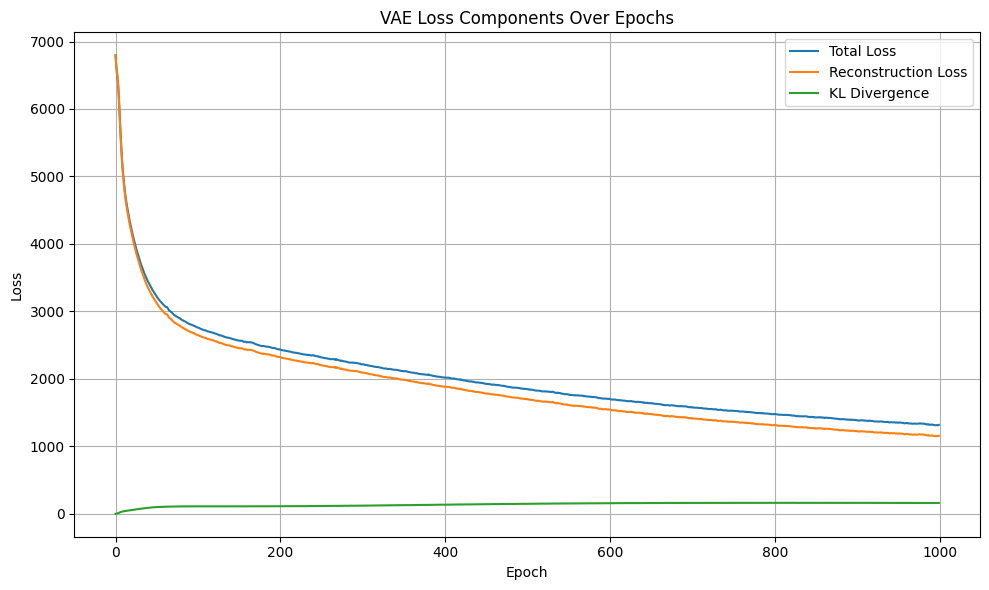

In [10]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

In [11]:
mu_all = get_latent_mu(model, X_tensor, device=device)

dim of latent mu: (331, 10)


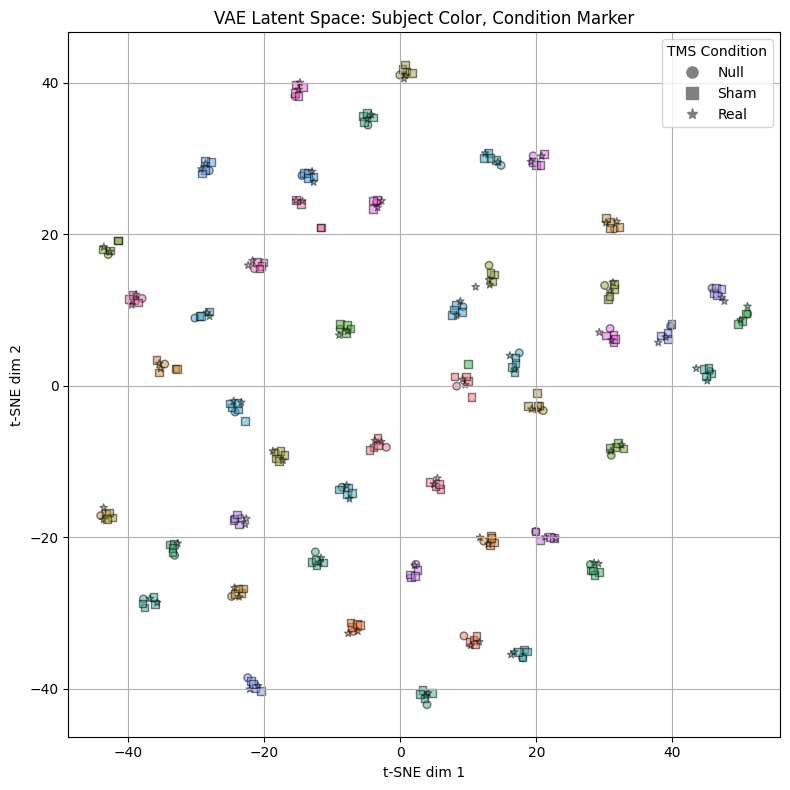

In [12]:
# plot 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -2.024, p = 0.0489


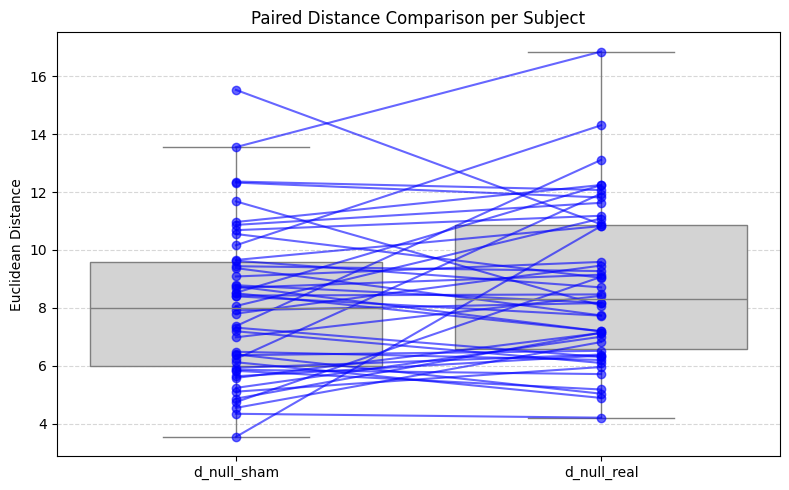

In [13]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)

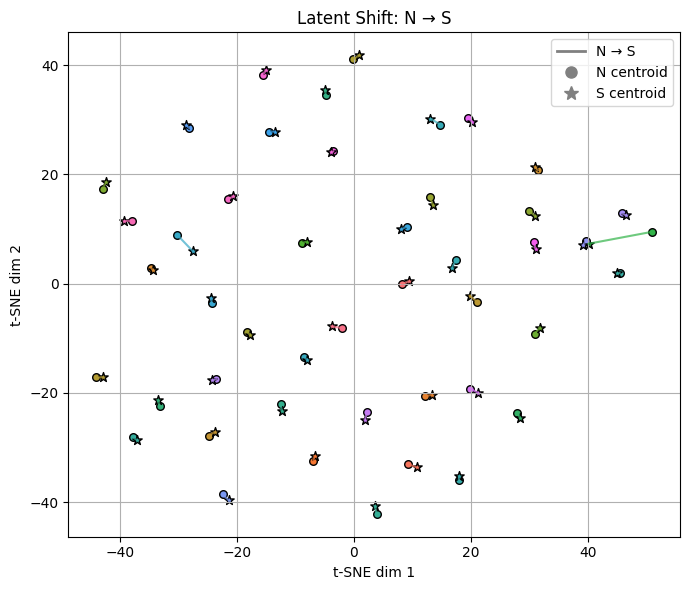

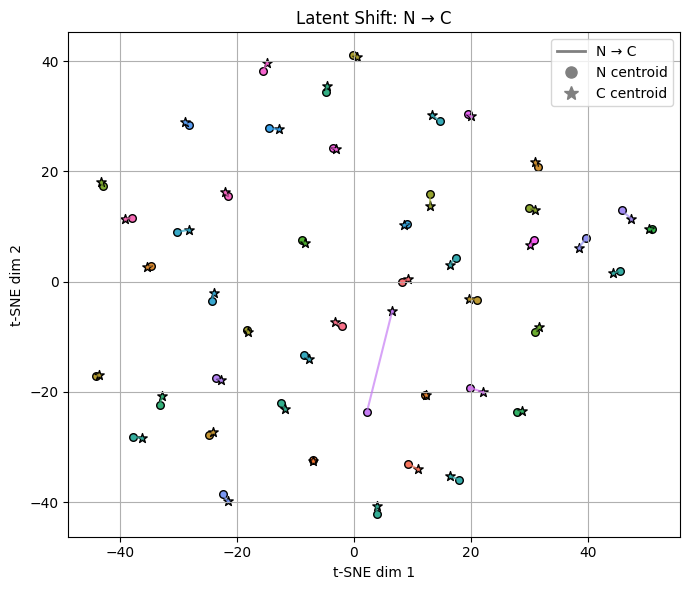

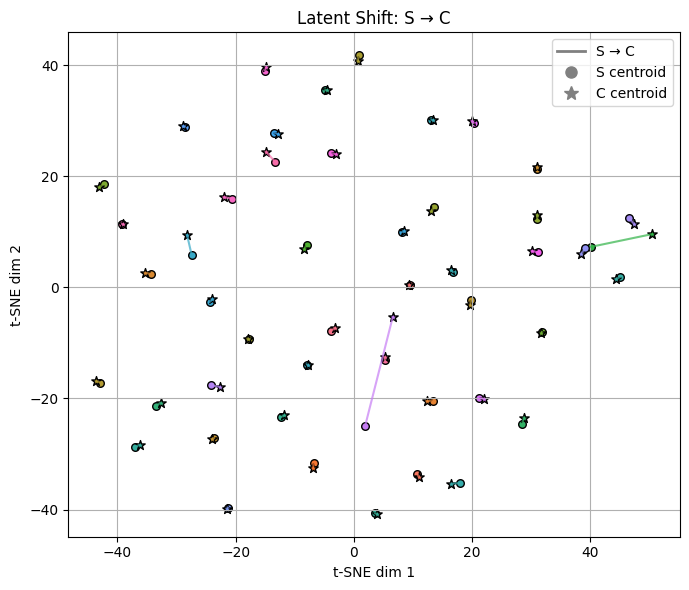

In [55]:
def plot_condition_shift(z_2d, all_tms_type, all_subject_id,
                         from_label='N', to_label='C',
                         label_map={'N': 0, 'S': 1, 'C': 2},
                         figsize=(7, 6),
                         title=None):
    """
    Plot centroid shift for a single condition contrast (e.g., Sham → Real).
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    y = np.array([label_map[t] for t in all_tms_type])
    unique_subjects = np.unique(all_subject_id)
    palette = sns.color_palette("husl", len(unique_subjects))
    subject_to_color = {subj: palette[i] for i, subj in enumerate(unique_subjects)}

    fig, ax = plt.subplots(figsize=figsize)

    for subj in unique_subjects:
        mask = np.array(all_subject_id) == subj
        subj_points = z_2d[mask]
        subj_labels = y[mask]

        if (label_map[from_label] not in subj_labels) or (label_map[to_label] not in subj_labels):
            continue  # skip if missing condition

        color = subject_to_color[subj]
        from_centroid = subj_points[subj_labels == label_map[from_label]].mean(axis=0)
        to_centroid = subj_points[subj_labels == label_map[to_label]].mean(axis=0)

        ax.plot(
            [from_centroid[0], to_centroid[0]],
            [from_centroid[1], to_centroid[1]],
            color=color, linestyle='-', linewidth=1.5, alpha=0.7
        )

        ax.scatter([from_centroid[0]], [from_centroid[1]], marker='o', color=color, s=30, edgecolor='black')
        ax.scatter([to_centroid[0]], [to_centroid[1]], marker='*', color=color, s=50, edgecolor='black')

    contrast_name = f"{from_label} → {to_label}"
    ax.set_title(title or f"Latent Shift: {contrast_name}")
    ax.set_xlabel('t-SNE dim 1')
    ax.set_ylabel('t-SNE dim 2')
    ax.grid(True)

    legend_elements = [
        Line2D([0], [0], linestyle='-', color='gray', lw=2, label=contrast_name),
        Line2D([0], [0], marker='o', color='gray', lw=0, markersize=8, label=f'{from_label} centroid'),
        Line2D([0], [0], marker='*', color='gray', lw=0, markersize=10, label=f'{to_label} centroid')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()


plot_condition_shift(z_2d, all_tms_type, all_subject_id, from_label='N', to_label='S')
plot_condition_shift(z_2d, all_tms_type, all_subject_id, from_label='N', to_label='C')
plot_condition_shift(z_2d, all_tms_type, all_subject_id, from_label='S', to_label='C')


In [56]:
df_session_dists = compute_per_session_dist_to_null(mu_all, all_subject_id, all_tms_type)
df_session_dists.head(10)

,subject,index,condition,distance_to_null
0,NODEAP_06,1,S,12.395501
1,NODEAP_06,2,S,13.554702
2,NODEAP_06,3,S,10.082585
3,NODEAP_06,4,C,13.599648
4,NODEAP_06,5,C,10.084601
5,NODEAP_06,6,S,12.733582
6,NODEAP_07,8,S,13.964909
7,NODEAP_07,9,S,13.812804
8,NODEAP_07,10,C,11.326782
9,NODEAP_07,11,S,35.919022


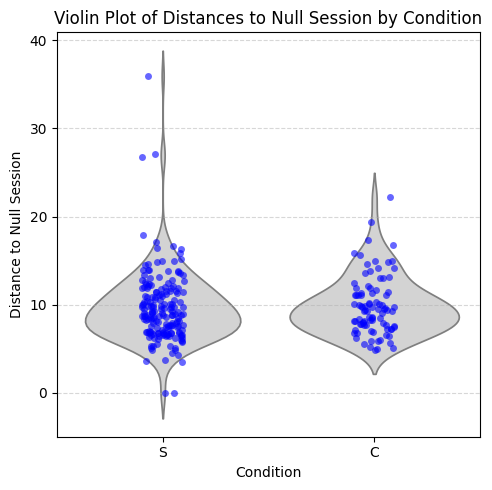

In [57]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df_session_dists, x='condition', y='distance_to_null', inner=None, color='lightgray')
sns.stripplot(data=df_session_dists, x='condition', y='distance_to_null',
              jitter=True, alpha=0.6, color='blue')

plt.title('Violin Plot of Distances to Null Session by Condition')
plt.ylabel('Distance to Null Session')
plt.xlabel('Condition')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
